U-Net을 통한 세그멘테이션 작업이 정상적으로 진행되었는가?
- KITTI 데이터셋 구성, U-Net 모델 훈련, 결과물 시각화의 한 사이클이 정상 수행되어 세그멘테이션 결과 이미지를 제출하였다.  
U-Net++ 모델이 성공적으로 구현되었는가?
- U-Net++ 모델을 스스로 구현하여 학습 진행 후 세그멘테이션 결과까지 정상 진행되었다.  
U-Net과 U-Net++ 두 모델의 성능이 정량적/정성적으로 잘 비교되었는가?
- U-Net++ 의 세그멘테이션 결과 사진과 IoU 계산치를 U-Net과 비교하여 우월함을 확인하였다.

In [8]:
import os
import math
import numpy as np
import torch
import torchvision.transforms as transforms

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize
import torch.nn as nn
import torch.optim as optim

# 데이터셋

In [9]:
def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        size=(224, 224),
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다.
                Resize(
                    width=224,
                    height=224
                    )
                ])

C:\Users\user\AppData\Local\Temp\ipykernel_27204\3831385234.py:5: UserWarning: Argument(s) 'height, width' are not valid for transform RandomSizedCrop
  RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop


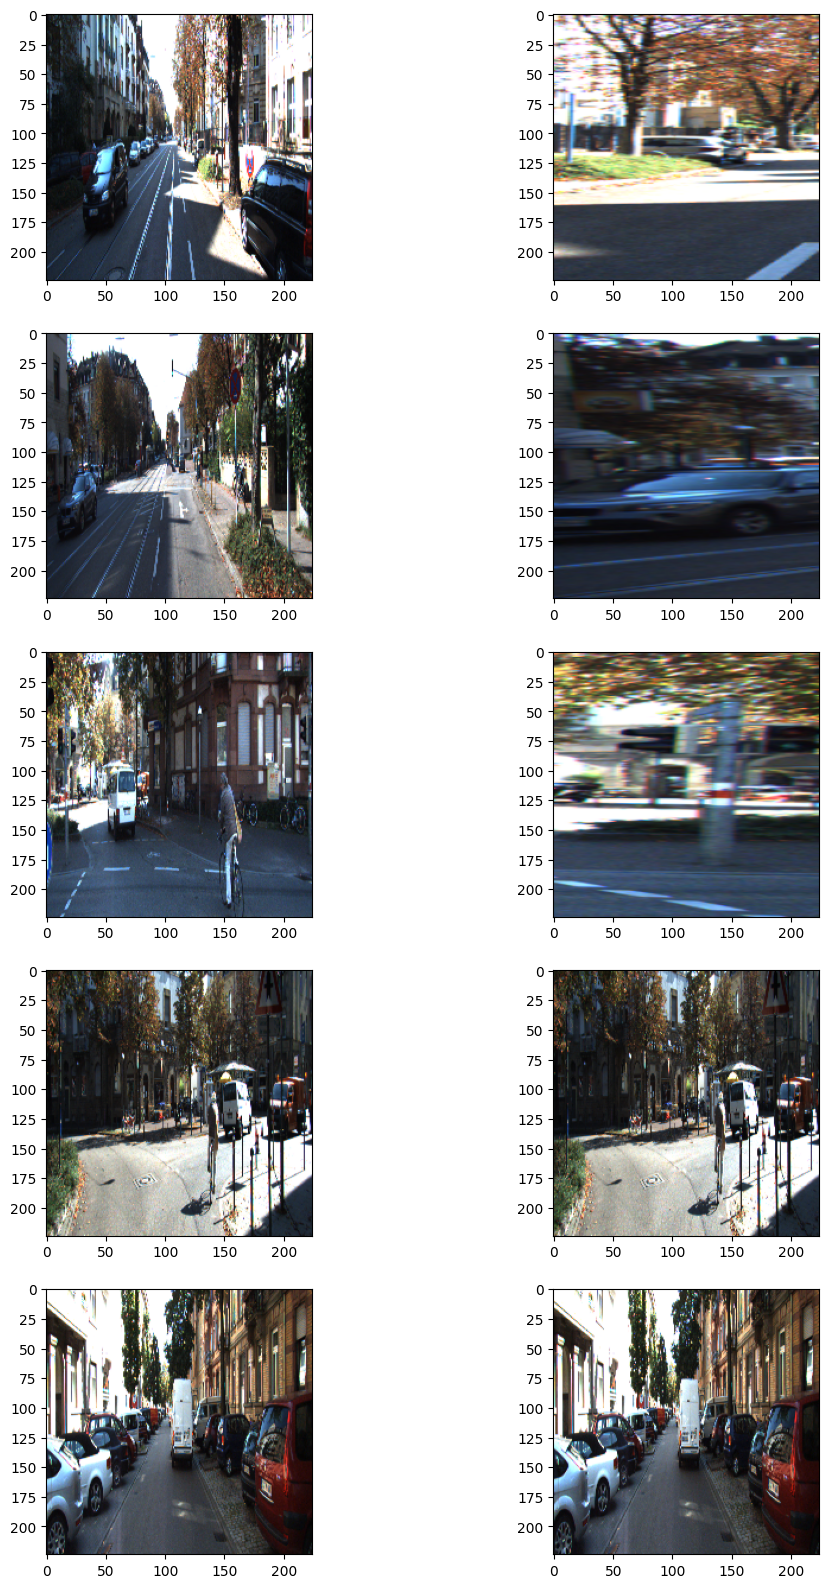

In [10]:
data_dir = "./data_semantics/training"
dir_path = "./data_semantics/testing"

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(data_dir, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i])
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지

plt.show()

In [11]:
from torch.utils.data import Dataset

class KittiDataset(Dataset):
    '''
    KittiDataset은 PyTorch의 Dataset을 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Dataset을 커스텀하여 사용합니다.
    '''
    def __init__(self,
                 dir_path,
                 img_size=(224, 224, 3),
                 output_size=(224, 224),
                 is_train=True,
                 augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Dataset이 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.is_train = is_train
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()을 통해 kitti dataset의 경로에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        input_images = sorted(glob(os.path.join(self.dir_path, "image_2", "*.png")))
        label_images = sorted(glob(os.path.join(self.dir_path, "semantic", "*.png")))

        assert len(input_images) == len(label_images)
        data = list(zip(input_images, label_images))

        if self.is_train:
            return data[:-30]
        return data[-30:]

    def __len__(self):
        # Dataset의 length로서 전체 dataset 크기를 반환합니다.
        return len(self.data)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize 및 augmentation이 적용된 input image이고
        # 출력은 semantic label입니다.
        input_img_path, output_path = self.data[index]

        _input = imread(input_img_path)
        _output = imread(output_path)

        # 특정 라벨을 이진 마스크로 변환
        _output = (_output == 7).astype(np.uint8) * 1

        data = {
            "image": _input,
            "mask": _output,
        }

        if self.augmentation:
            augmented = self.augmentation(**data)
            _input = augmented["image"] / 255.0  # Normalize
            _output = augmented["mask"]

        # 📌 target 차원 확장 (H, W) → (1, H, W)
        _output = np.expand_dims(_output, axis=0)

        return (
            torch.tensor(_input, dtype=torch.float32).permute(2, 0, 1),  # (H, W, C) → (C, H, W)
            torch.tensor(_output, dtype=torch.float32)  # (1, H, W) 형식 유지
        )

    def shuffle_data(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습 중인 경우에 데이터를 random shuffle합니다.
        if self.is_train:
            np.random.shuffle(self.data)

In [12]:
from torch.utils.data import DataLoader

# Augmentation 설정
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)

train_dataset = KittiDataset(
    data_dir,
    augmentation=augmentation,
    is_train=True
)

test_dataset = KittiDataset(
    data_dir,
    augmentation=test_preproc,
    is_train=False
)

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

C:\Users\user\AppData\Local\Temp\ipykernel_27204\3831385234.py:5: UserWarning: Argument(s) 'height, width' are not valid for transform RandomSizedCrop
  RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop


# U-Net 모델

In [13]:
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, input_channels=3, output_channels=1):
        super(UNet, self).__init__()

        # Contracting Path (Encoder)
        self.enc1 = self.double_conv(input_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = self.double_conv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = self.double_conv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = self.double_conv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = self.double_conv(512, 1024)
        self.dropout = nn.Dropout(0.5)

        # Expanding Path (Decoder)
        self.up6 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec6 = self.double_conv(1024, 512)
        self.up7 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec7 = self.double_conv(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec8 = self.double_conv(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec9 = self.double_conv(128, 64)

        # Output layer
        self.final = nn.Conv2d(64, output_channels, kernel_size=1)

    def double_conv(self, in_channels, out_channels):
        """2개의 Conv Layer로 이루어진 블록"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        # Encoder
        c1 = self.enc1(x)
        p1 = self.pool1(c1)
        c2 = self.enc2(p1)
        p2 = self.pool2(c2)
        c3 = self.enc3(p2)
        p3 = self.pool3(c3)
        c4 = self.enc4(p3)
        p4 = self.pool4(c4)

        # Bottleneck
        c5 = self.bottleneck(p4)
        c5 = self.dropout(c5)

        # Decoder
        u6 = self.up6(c5)
        u6 = torch.cat([u6, c4], dim=1)
        c6 = self.dec6(u6)

        u7 = self.up7(c6)
        u7 = torch.cat([u7, c3], dim=1)
        c7 = self.dec7(u7)

        u8 = self.up8(c7)
        u8 = torch.cat([u8, c2], dim=1)
        c8 = self.dec8(u8)

        u9 = self.up9(c8)
        u9 = torch.cat([u9, c1], dim=1)
        c9 = self.dec9(u9)

        # Output
        output = torch.sigmoid(self.final(c9))
        return output

# 모델 학습

Epoch 1/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.42it/s, loss=0.606, acc=0.844]


Epoch 1/300 | Loss: 0.8607 (Val: 0.6315) | Acc: 0.7844 (Val: 0.7526)


Epoch 2/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.68it/s, loss=0.625, acc=0.737]


Epoch 2/300 | Loss: 0.6268 (Val: 0.6024) | Acc: 0.7681 (Val: 0.7526)


Epoch 3/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.64it/s, loss=0.618, acc=0.735]


Epoch 3/300 | Loss: 0.6222 (Val: 0.6058) | Acc: 0.7860 (Val: 0.7526)


Epoch 4/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.63it/s, loss=0.549, acc=0.733]


Epoch 4/300 | Loss: 0.5242 (Val: 0.5209) | Acc: 0.7810 (Val: 0.7526)


Epoch 5/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.63it/s, loss=0.473, acc=0.831]


Epoch 5/300 | Loss: 0.4870 (Val: 0.5285) | Acc: 0.7741 (Val: 0.7526)


Epoch 6/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.71it/s, loss=0.41, acc=0.792] 


Epoch 6/300 | Loss: 0.4384 (Val: 0.6988) | Acc: 0.7901 (Val: 0.7526)


Epoch 7/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.66it/s, loss=0.451, acc=0.752]


Epoch 7/300 | Loss: 0.4499 (Val: 0.4651) | Acc: 0.7799 (Val: 0.7526)


Epoch 8/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.67it/s, loss=0.45, acc=0.759] 


Epoch 8/300 | Loss: 0.4298 (Val: 0.4370) | Acc: 0.7707 (Val: 0.7526)


Epoch 9/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.66it/s, loss=1.11, acc=0.792]


Epoch 9/300 | Loss: 0.4265 (Val: 0.5762) | Acc: 0.8148 (Val: 0.7597)


Epoch 10/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.63it/s, loss=0.494, acc=0.705]


Epoch 10/300 | Loss: 0.4916 (Val: 0.4742) | Acc: 0.7685 (Val: 0.7526)
--> Checkpoint saved: ./data_semantics/seg_model_unet_epoch_10.pth


Epoch 11/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.64it/s, loss=0.364, acc=0.78] 


Epoch 11/300 | Loss: 0.4285 (Val: 0.4801) | Acc: 0.7752 (Val: 0.7526)


Epoch 12/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.68it/s, loss=0.308, acc=0.861]


Epoch 12/300 | Loss: 0.3767 (Val: 0.4341) | Acc: 0.7831 (Val: 0.8254)


Epoch 13/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.71it/s, loss=0.325, acc=0.874]


Epoch 13/300 | Loss: 0.3402 (Val: 0.3770) | Acc: 0.8670 (Val: 0.8616)


Epoch 14/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.68it/s, loss=0.239, acc=0.906]


Epoch 14/300 | Loss: 0.3048 (Val: 0.3250) | Acc: 0.8822 (Val: 0.8879)


Epoch 15/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.71it/s, loss=0.371, acc=0.832]


Epoch 15/300 | Loss: 0.2890 (Val: 0.4320) | Acc: 0.8833 (Val: 0.8383)


Epoch 16/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.71it/s, loss=0.238, acc=0.914]


Epoch 16/300 | Loss: 0.2767 (Val: 0.3621) | Acc: 0.8921 (Val: 0.8713)


Epoch 17/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.69it/s, loss=0.266, acc=0.902]


Epoch 17/300 | Loss: 0.2701 (Val: 0.4087) | Acc: 0.8918 (Val: 0.8589)


Epoch 18/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.64it/s, loss=0.457, acc=0.879]


Epoch 18/300 | Loss: 0.3053 (Val: 0.4624) | Acc: 0.8753 (Val: 0.8149)


Epoch 19/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.66it/s, loss=0.264, acc=0.889]


Epoch 19/300 | Loss: 0.2723 (Val: 0.3627) | Acc: 0.8876 (Val: 0.8372)


Epoch 20/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.67it/s, loss=0.309, acc=0.855]


Epoch 20/300 | Loss: 0.2815 (Val: 0.3682) | Acc: 0.8780 (Val: 0.8752)
--> Checkpoint saved: ./data_semantics/seg_model_unet_epoch_20.pth


Epoch 21/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.67it/s, loss=0.361, acc=0.854]


Epoch 21/300 | Loss: 0.2635 (Val: 0.5026) | Acc: 0.9024 (Val: 0.8224)


Epoch 22/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.67it/s, loss=0.195, acc=0.936]


Epoch 22/300 | Loss: 0.2546 (Val: 0.3798) | Acc: 0.9069 (Val: 0.8736)


Epoch 23/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.68it/s, loss=0.181, acc=0.928]


Epoch 23/300 | Loss: 0.2171 (Val: 0.3986) | Acc: 0.9252 (Val: 0.8890)


Epoch 24/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.69it/s, loss=0.166, acc=0.929]


Epoch 24/300 | Loss: 0.2071 (Val: 0.3048) | Acc: 0.9221 (Val: 0.9032)


Epoch 25/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.67it/s, loss=0.214, acc=0.905]


Epoch 25/300 | Loss: 0.1952 (Val: 0.3424) | Acc: 0.9197 (Val: 0.8948)


Epoch 26/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.71it/s, loss=0.205, acc=0.92] 


Epoch 26/300 | Loss: 0.2042 (Val: 0.3105) | Acc: 0.9275 (Val: 0.8972)


Epoch 27/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.71it/s, loss=0.155, acc=0.945]


Epoch 27/300 | Loss: 0.1993 (Val: 0.3378) | Acc: 0.9228 (Val: 0.8883)


Epoch 28/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.68it/s, loss=0.216, acc=0.906]


Epoch 28/300 | Loss: 0.1932 (Val: 0.2832) | Acc: 0.9239 (Val: 0.9045)


Epoch 29/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.73it/s, loss=0.166, acc=0.924]


Epoch 29/300 | Loss: 0.1713 (Val: 0.2869) | Acc: 0.9342 (Val: 0.9062)


Epoch 30/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.79it/s, loss=0.208, acc=0.917]


Epoch 30/300 | Loss: 0.1767 (Val: 0.3449) | Acc: 0.9340 (Val: 0.8825)
--> Checkpoint saved: ./data_semantics/seg_model_unet_epoch_30.pth


Epoch 31/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.75it/s, loss=0.159, acc=0.941]


Epoch 31/300 | Loss: 0.1719 (Val: 0.3157) | Acc: 0.9366 (Val: 0.8928)


Epoch 32/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.74it/s, loss=0.238, acc=0.899]


Epoch 32/300 | Loss: 0.1709 (Val: 0.2886) | Acc: 0.9331 (Val: 0.9005)


Epoch 33/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.69it/s, loss=0.289, acc=0.909]


Epoch 33/300 | Loss: 0.1789 (Val: 0.2951) | Acc: 0.9331 (Val: 0.8981)


Epoch 34/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.67it/s, loss=0.111, acc=0.957]


Epoch 34/300 | Loss: 0.1822 (Val: 0.2879) | Acc: 0.9309 (Val: 0.9010)


Epoch 35/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.71it/s, loss=0.154, acc=0.945]


Epoch 35/300 | Loss: 0.1519 (Val: 0.3865) | Acc: 0.9402 (Val: 0.8787)


Epoch 36/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.67it/s, loss=0.195, acc=0.919]


Epoch 36/300 | Loss: 0.1780 (Val: 0.2508) | Acc: 0.9341 (Val: 0.9075)


Epoch 37/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.67it/s, loss=0.125, acc=0.949]


Epoch 37/300 | Loss: 0.1527 (Val: 0.3556) | Acc: 0.9426 (Val: 0.8952)


Epoch 38/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.76it/s, loss=0.218, acc=0.91] 


Epoch 38/300 | Loss: 0.2053 (Val: 0.3147) | Acc: 0.9238 (Val: 0.8811)


Epoch 39/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.73it/s, loss=0.171, acc=0.922]


Epoch 39/300 | Loss: 0.1872 (Val: 0.2489) | Acc: 0.9248 (Val: 0.9059)


Epoch 40/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.73it/s, loss=0.131, acc=0.947]


Epoch 40/300 | Loss: 0.1746 (Val: 0.2441) | Acc: 0.9341 (Val: 0.9137)
--> Checkpoint saved: ./data_semantics/seg_model_unet_epoch_40.pth


Epoch 41/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.71it/s, loss=0.172, acc=0.933]


Epoch 41/300 | Loss: 0.1960 (Val: 0.2686) | Acc: 0.9253 (Val: 0.9164)


Epoch 42/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.79it/s, loss=0.153, acc=0.934]


Epoch 42/300 | Loss: 0.1746 (Val: 0.3041) | Acc: 0.9336 (Val: 0.9047)


Epoch 43/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.83it/s, loss=0.177, acc=0.923]


Epoch 43/300 | Loss: 0.1591 (Val: 0.2843) | Acc: 0.9397 (Val: 0.8994)


Epoch 44/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.80it/s, loss=0.125, acc=0.954]


Epoch 44/300 | Loss: 0.1448 (Val: 0.2477) | Acc: 0.9453 (Val: 0.9147)


Epoch 45/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.74it/s, loss=0.149, acc=0.943]


Epoch 45/300 | Loss: 0.1522 (Val: 0.2778) | Acc: 0.9406 (Val: 0.9062)


Epoch 46/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.72it/s, loss=0.143, acc=0.945]


Epoch 46/300 | Loss: 0.1734 (Val: 0.3486) | Acc: 0.9320 (Val: 0.8944)


Epoch 47/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.69it/s, loss=0.146, acc=0.938]


Epoch 47/300 | Loss: 0.1650 (Val: 0.2683) | Acc: 0.9363 (Val: 0.9071)


Epoch 48/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.67it/s, loss=0.144, acc=0.939]


Epoch 48/300 | Loss: 0.1615 (Val: 0.2581) | Acc: 0.9357 (Val: 0.9092)


Epoch 49/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.67it/s, loss=0.139, acc=0.95] 


Epoch 49/300 | Loss: 0.1532 (Val: 0.2563) | Acc: 0.9399 (Val: 0.9092)


Epoch 50/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.65it/s, loss=0.135, acc=0.941]


Epoch 50/300 | Loss: 0.1468 (Val: 0.2506) | Acc: 0.9401 (Val: 0.9101)
--> Checkpoint saved: ./data_semantics/seg_model_unet_epoch_50.pth


Epoch 51/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.66it/s, loss=0.12, acc=0.953] 


Epoch 51/300 | Loss: 0.1492 (Val: 0.2563) | Acc: 0.9403 (Val: 0.9076)


Epoch 52/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.66it/s, loss=0.115, acc=0.959]


Epoch 52/300 | Loss: 0.1415 (Val: 0.1956) | Acc: 0.9431 (Val: 0.9230)


Epoch 53/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.68it/s, loss=0.188, acc=0.936]


Epoch 53/300 | Loss: 0.1501 (Val: 0.2299) | Acc: 0.9433 (Val: 0.9145)


Epoch 54/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.70it/s, loss=0.187, acc=0.922]


Epoch 54/300 | Loss: 0.1546 (Val: 0.2492) | Acc: 0.9396 (Val: 0.9120)


Epoch 55/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.66it/s, loss=0.122, acc=0.955]


Epoch 55/300 | Loss: 0.1440 (Val: 0.2358) | Acc: 0.9449 (Val: 0.9177)


Epoch 56/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.70it/s, loss=0.109, acc=0.959]


Epoch 56/300 | Loss: 0.1435 (Val: 0.2847) | Acc: 0.9418 (Val: 0.9106)


Epoch 57/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.67it/s, loss=0.192, acc=0.925]


Epoch 57/300 | Loss: 0.1390 (Val: 0.2337) | Acc: 0.9467 (Val: 0.9249)


Epoch 58/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.72it/s, loss=0.142, acc=0.949]


Epoch 58/300 | Loss: 0.1315 (Val: 0.3361) | Acc: 0.9486 (Val: 0.9129)


Epoch 59/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.69it/s, loss=0.163, acc=0.934]


Epoch 59/300 | Loss: 0.1487 (Val: 0.2556) | Acc: 0.9437 (Val: 0.9143)


Epoch 60/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.71it/s, loss=0.163, acc=0.933]


Epoch 60/300 | Loss: 0.1393 (Val: 0.2262) | Acc: 0.9442 (Val: 0.9178)
--> Checkpoint saved: ./data_semantics/seg_model_unet_epoch_60.pth


Epoch 61/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.70it/s, loss=0.105, acc=0.976]


Epoch 61/300 | Loss: 0.1414 (Val: 0.1936) | Acc: 0.9458 (Val: 0.9199)


Epoch 62/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.74it/s, loss=0.137, acc=0.942]


Epoch 62/300 | Loss: 0.1601 (Val: 0.2750) | Acc: 0.9352 (Val: 0.8953)


Epoch 63/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.73it/s, loss=0.23, acc=0.934] 


Epoch 63/300 | Loss: 0.1553 (Val: 0.2941) | Acc: 0.9400 (Val: 0.9009)


Epoch 64/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.69it/s, loss=0.142, acc=0.942]


Epoch 64/300 | Loss: 0.1903 (Val: 0.2458) | Acc: 0.9252 (Val: 0.9079)


Epoch 65/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.71it/s, loss=0.161, acc=0.934]


Epoch 65/300 | Loss: 0.1608 (Val: 0.2873) | Acc: 0.9370 (Val: 0.8970)


Epoch 66/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.71it/s, loss=0.119, acc=0.955]


Epoch 66/300 | Loss: 0.1508 (Val: 0.2211) | Acc: 0.9392 (Val: 0.9137)


Epoch 67/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.66it/s, loss=0.165, acc=0.937]


Epoch 67/300 | Loss: 0.1491 (Val: 0.2479) | Acc: 0.9430 (Val: 0.9125)


Epoch 68/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.78it/s, loss=0.234, acc=0.902]


Epoch 68/300 | Loss: 0.1462 (Val: 0.2598) | Acc: 0.9404 (Val: 0.9018)


Epoch 69/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.80it/s, loss=0.145, acc=0.938]


Epoch 69/300 | Loss: 0.1501 (Val: 0.2871) | Acc: 0.9418 (Val: 0.9021)


Epoch 70/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.82it/s, loss=0.142, acc=0.955]


Epoch 70/300 | Loss: 0.1596 (Val: 0.2180) | Acc: 0.9369 (Val: 0.9144)
--> Checkpoint saved: ./data_semantics/seg_model_unet_epoch_70.pth


Epoch 71/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.76it/s, loss=0.117, acc=0.958]


Epoch 71/300 | Loss: 0.1384 (Val: 0.2293) | Acc: 0.9431 (Val: 0.9134)


Epoch 72/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.78it/s, loss=0.137, acc=0.948]


Epoch 72/300 | Loss: 0.1313 (Val: 0.2120) | Acc: 0.9488 (Val: 0.9190)


Epoch 73/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.74it/s, loss=0.148, acc=0.948]


Epoch 73/300 | Loss: 0.1217 (Val: 0.2296) | Acc: 0.9498 (Val: 0.9085)


Epoch 74/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.74it/s, loss=0.174, acc=0.928]


Epoch 74/300 | Loss: 0.1513 (Val: 0.2104) | Acc: 0.9397 (Val: 0.9190)


Epoch 75/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.71it/s, loss=0.111, acc=0.959]


Epoch 75/300 | Loss: 0.1308 (Val: 0.2370) | Acc: 0.9460 (Val: 0.9091)


Epoch 76/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.72it/s, loss=0.15, acc=0.924] 


Epoch 76/300 | Loss: 0.1325 (Val: 0.2512) | Acc: 0.9452 (Val: 0.9197)


Epoch 77/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.68it/s, loss=0.151, acc=0.931]


Epoch 77/300 | Loss: 0.1295 (Val: 0.3421) | Acc: 0.9505 (Val: 0.9153)


Epoch 78/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.70it/s, loss=0.213, acc=0.894]


Epoch 78/300 | Loss: 0.1471 (Val: 0.2031) | Acc: 0.9393 (Val: 0.9201)


Epoch 79/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.66it/s, loss=0.144, acc=0.939]


Epoch 79/300 | Loss: 0.1514 (Val: 0.2099) | Acc: 0.9419 (Val: 0.9139)


Epoch 80/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.70it/s, loss=0.0963, acc=0.965]


Epoch 80/300 | Loss: 0.1348 (Val: 0.2382) | Acc: 0.9465 (Val: 0.9119)
--> Checkpoint saved: ./data_semantics/seg_model_unet_epoch_80.pth


Epoch 81/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.75it/s, loss=0.219, acc=0.928]


Epoch 81/300 | Loss: 0.1424 (Val: 0.2143) | Acc: 0.9443 (Val: 0.9177)


Epoch 82/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.68it/s, loss=0.153, acc=0.915]


Epoch 82/300 | Loss: 0.1431 (Val: 0.2422) | Acc: 0.9378 (Val: 0.9135)


Epoch 83/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.65it/s, loss=0.137, acc=0.953]


Epoch 83/300 | Loss: 0.1410 (Val: 0.3027) | Acc: 0.9447 (Val: 0.8941)


Epoch 84/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.65it/s, loss=0.11, acc=0.957] 


Epoch 84/300 | Loss: 0.1492 (Val: 0.2303) | Acc: 0.9421 (Val: 0.9151)


Epoch 85/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.78it/s, loss=0.262, acc=0.922]


Epoch 85/300 | Loss: 0.1419 (Val: 0.1914) | Acc: 0.9477 (Val: 0.9169)


Epoch 86/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.77it/s, loss=0.103, acc=0.956]


Epoch 86/300 | Loss: 0.1345 (Val: 0.2397) | Acc: 0.9464 (Val: 0.9160)


Epoch 87/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.69it/s, loss=0.141, acc=0.95]


Epoch 87/300 | Loss: 0.1933 (Val: 0.2347) | Acc: 0.9339 (Val: 0.9137)


Epoch 88/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.65it/s, loss=0.237, acc=0.91] 


Epoch 88/300 | Loss: 0.2581 (Val: 0.2719) | Acc: 0.9028 (Val: 0.8776)


Epoch 89/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.67it/s, loss=0.268, acc=0.895]


Epoch 89/300 | Loss: 0.1990 (Val: 0.4516) | Acc: 0.9273 (Val: 0.8926)


Epoch 90/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.70it/s, loss=0.125, acc=0.948]


Epoch 90/300 | Loss: 0.1474 (Val: 0.2837) | Acc: 0.9428 (Val: 0.9146)
--> Checkpoint saved: ./data_semantics/seg_model_unet_epoch_90.pth


Epoch 91/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.65it/s, loss=0.204, acc=0.918]


Epoch 91/300 | Loss: 0.1486 (Val: 0.2667) | Acc: 0.9426 (Val: 0.9122)


Epoch 92/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.79it/s, loss=0.0852, acc=0.972]


Epoch 92/300 | Loss: 0.1429 (Val: 0.3122) | Acc: 0.9451 (Val: 0.9177)


Epoch 93/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.67it/s, loss=0.14, acc=0.943]  


Epoch 93/300 | Loss: 0.1393 (Val: 0.2538) | Acc: 0.9448 (Val: 0.9108)


Epoch 94/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.76it/s, loss=0.135, acc=0.94]


Epoch 94/300 | Loss: 0.1522 (Val: 0.2245) | Acc: 0.9395 (Val: 0.9184)


Epoch 95/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.83it/s, loss=0.123, acc=0.953]


Epoch 95/300 | Loss: 0.1569 (Val: 0.2900) | Acc: 0.9379 (Val: 0.9069)


Epoch 96/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.77it/s, loss=0.0855, acc=0.973]


Epoch 96/300 | Loss: 0.1273 (Val: 0.2766) | Acc: 0.9481 (Val: 0.9190)


Epoch 97/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.77it/s, loss=0.308, acc=0.888]


Epoch 97/300 | Loss: 0.1661 (Val: 0.2338) | Acc: 0.9351 (Val: 0.9188)


Epoch 98/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.77it/s, loss=0.0927, acc=0.97]


Epoch 98/300 | Loss: 0.1648 (Val: 0.2682) | Acc: 0.9390 (Val: 0.9165)


Epoch 99/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.78it/s, loss=0.137, acc=0.945]


Epoch 99/300 | Loss: 0.1331 (Val: 0.2811) | Acc: 0.9509 (Val: 0.9167)


Epoch 100/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.76it/s, loss=0.162, acc=0.928]


Epoch 100/300 | Loss: 0.1487 (Val: 0.2070) | Acc: 0.9434 (Val: 0.9032)
--> Checkpoint saved: ./data_semantics/seg_model_unet_epoch_100.pth


Epoch 101/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.72it/s, loss=0.108, acc=0.96] 


Epoch 101/300 | Loss: 0.1431 (Val: 0.2782) | Acc: 0.9423 (Val: 0.9138)


Epoch 102/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.66it/s, loss=0.129, acc=0.95] 


Epoch 102/300 | Loss: 0.1394 (Val: 0.2006) | Acc: 0.9468 (Val: 0.9166)


Epoch 103/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.67it/s, loss=0.201, acc=0.926]


Epoch 103/300 | Loss: 0.1392 (Val: 0.3820) | Acc: 0.9455 (Val: 0.9061)


Epoch 104/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.68it/s, loss=0.0876, acc=0.967]


Epoch 104/300 | Loss: 0.1330 (Val: 0.2113) | Acc: 0.9479 (Val: 0.9215)


Epoch 105/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.65it/s, loss=0.137, acc=0.938]


Epoch 105/300 | Loss: 0.1202 (Val: 0.2840) | Acc: 0.9515 (Val: 0.9155)


Epoch 106/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.58it/s, loss=0.102, acc=0.956] 


Epoch 106/300 | Loss: 0.1166 (Val: 0.2477) | Acc: 0.9534 (Val: 0.9211)


Epoch 107/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.63it/s, loss=0.193, acc=0.921]


Epoch 107/300 | Loss: 0.1442 (Val: 0.2473) | Acc: 0.9473 (Val: 0.9205)


Epoch 108/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.62it/s, loss=0.113, acc=0.954]


Epoch 108/300 | Loss: 0.1286 (Val: 0.2724) | Acc: 0.9519 (Val: 0.9215)


Epoch 109/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.66it/s, loss=0.116, acc=0.96]  


Epoch 109/300 | Loss: 0.1165 (Val: 0.2728) | Acc: 0.9525 (Val: 0.9189)


Epoch 110/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.63it/s, loss=0.0996, acc=0.958]


Epoch 110/300 | Loss: 0.1051 (Val: 0.3493) | Acc: 0.9570 (Val: 0.9153)
--> Checkpoint saved: ./data_semantics/seg_model_unet_epoch_110.pth


Epoch 111/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.65it/s, loss=0.177, acc=0.921]


Epoch 111/300 | Loss: 0.1530 (Val: 0.2008) | Acc: 0.9417 (Val: 0.9189)


Epoch 112/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.64it/s, loss=0.134, acc=0.948]


Epoch 112/300 | Loss: 0.1453 (Val: 0.2345) | Acc: 0.9449 (Val: 0.9198)


Epoch 113/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.64it/s, loss=0.161, acc=0.935]


Epoch 113/300 | Loss: 0.1419 (Val: 0.2087) | Acc: 0.9415 (Val: 0.9215)


Epoch 114/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.62it/s, loss=0.189, acc=0.922]


Epoch 114/300 | Loss: 0.1225 (Val: 0.2603) | Acc: 0.9515 (Val: 0.9211)


Epoch 115/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.63it/s, loss=0.202, acc=0.935]


Epoch 115/300 | Loss: 0.1209 (Val: 0.2563) | Acc: 0.9522 (Val: 0.9217)


Epoch 116/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.64it/s, loss=0.114, acc=0.952]


Epoch 116/300 | Loss: 0.1216 (Val: 0.2202) | Acc: 0.9489 (Val: 0.9212)


Epoch 117/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.63it/s, loss=0.0883, acc=0.966]


Epoch 117/300 | Loss: 0.1167 (Val: 0.2389) | Acc: 0.9522 (Val: 0.9203)


Epoch 118/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.63it/s, loss=0.076, acc=0.967]


Epoch 118/300 | Loss: 0.1039 (Val: 0.2400) | Acc: 0.9577 (Val: 0.9245)


Epoch 119/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.62it/s, loss=0.117, acc=0.961]


Epoch 119/300 | Loss: 0.1141 (Val: 0.2555) | Acc: 0.9534 (Val: 0.9184)


Epoch 120/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.63it/s, loss=0.0942, acc=0.962]


Epoch 120/300 | Loss: 0.1098 (Val: 0.1812) | Acc: 0.9563 (Val: 0.9320)
--> Checkpoint saved: ./data_semantics/seg_model_unet_epoch_120.pth


Epoch 121/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.62it/s, loss=0.0944, acc=0.969]


Epoch 121/300 | Loss: 0.1112 (Val: 0.2822) | Acc: 0.9552 (Val: 0.9225)


Epoch 122/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.69it/s, loss=0.137, acc=0.942] 


Epoch 122/300 | Loss: 0.1052 (Val: 0.3136) | Acc: 0.9570 (Val: 0.9203)


Epoch 123/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.76it/s, loss=0.101, acc=0.958]


Epoch 123/300 | Loss: 0.1186 (Val: 0.1977) | Acc: 0.9554 (Val: 0.9295)


Epoch 124/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.79it/s, loss=0.111, acc=0.951] 


Epoch 124/300 | Loss: 0.1110 (Val: 0.2919) | Acc: 0.9561 (Val: 0.9176)


Epoch 125/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.70it/s, loss=0.124, acc=0.948]


Epoch 125/300 | Loss: 0.1162 (Val: 0.2205) | Acc: 0.9517 (Val: 0.9258)


Epoch 126/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.71it/s, loss=0.101, acc=0.955] 


Epoch 126/300 | Loss: 0.1062 (Val: 0.2666) | Acc: 0.9559 (Val: 0.9221)


Epoch 127/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.65it/s, loss=0.16, acc=0.932] 


Epoch 127/300 | Loss: 0.1157 (Val: 0.2092) | Acc: 0.9537 (Val: 0.9230)


Epoch 128/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.69it/s, loss=0.147, acc=0.932] 


Epoch 128/300 | Loss: 0.1210 (Val: 0.2533) | Acc: 0.9531 (Val: 0.9164)


Epoch 129/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.75it/s, loss=0.0918, acc=0.963]


Epoch 129/300 | Loss: 0.1211 (Val: 0.2090) | Acc: 0.9509 (Val: 0.9268)


Epoch 130/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.66it/s, loss=0.114, acc=0.96] 


Epoch 130/300 | Loss: 0.1118 (Val: 0.2341) | Acc: 0.9545 (Val: 0.9245)
--> Checkpoint saved: ./data_semantics/seg_model_unet_epoch_130.pth


Epoch 131/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.64it/s, loss=0.0826, acc=0.967]


Epoch 131/300 | Loss: 0.1010 (Val: 0.2366) | Acc: 0.9602 (Val: 0.9262)


Epoch 132/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.71it/s, loss=0.141, acc=0.934] 


Epoch 132/300 | Loss: 0.1144 (Val: 0.1674) | Acc: 0.9541 (Val: 0.9358)


Epoch 133/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.78it/s, loss=0.102, acc=0.958]


Epoch 133/300 | Loss: 0.1282 (Val: 0.2309) | Acc: 0.9465 (Val: 0.9236)


Epoch 134/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.74it/s, loss=0.221, acc=0.938]


Epoch 134/300 | Loss: 0.1245 (Val: 0.2296) | Acc: 0.9523 (Val: 0.9274)


Epoch 135/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.70it/s, loss=0.116, acc=0.949]


Epoch 135/300 | Loss: 0.1271 (Val: 0.2419) | Acc: 0.9487 (Val: 0.9249)


Epoch 136/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.63it/s, loss=0.158, acc=0.931] 


Epoch 136/300 | Loss: 0.1167 (Val: 0.2308) | Acc: 0.9509 (Val: 0.9248)


Epoch 137/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.66it/s, loss=0.0775, acc=0.971]


Epoch 137/300 | Loss: 0.1112 (Val: 0.2101) | Acc: 0.9554 (Val: 0.9277)


Epoch 138/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.63it/s, loss=0.123, acc=0.956]


Epoch 138/300 | Loss: 0.1094 (Val: 0.2655) | Acc: 0.9559 (Val: 0.9158)


Epoch 139/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.67it/s, loss=0.119, acc=0.952] 


Epoch 139/300 | Loss: 0.1077 (Val: 0.2099) | Acc: 0.9563 (Val: 0.9232)


Epoch 140/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.73it/s, loss=0.0504, acc=0.978]


Epoch 140/300 | Loss: 0.0923 (Val: 0.2274) | Acc: 0.9623 (Val: 0.9323)
--> Checkpoint saved: ./data_semantics/seg_model_unet_epoch_140.pth


Epoch 141/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.75it/s, loss=0.126, acc=0.949]


Epoch 141/300 | Loss: 0.1061 (Val: 0.1931) | Acc: 0.9584 (Val: 0.9356)


Epoch 142/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.69it/s, loss=0.13, acc=0.947]  


Epoch 142/300 | Loss: 0.1226 (Val: 0.1625) | Acc: 0.9517 (Val: 0.9311)


Epoch 143/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.68it/s, loss=0.0951, acc=0.956]


Epoch 143/300 | Loss: 0.1095 (Val: 0.2104) | Acc: 0.9557 (Val: 0.9256)


Epoch 144/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.72it/s, loss=0.0736, acc=0.971]


Epoch 144/300 | Loss: 0.0962 (Val: 0.2560) | Acc: 0.9618 (Val: 0.9154)


Epoch 145/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.78it/s, loss=0.0929, acc=0.959]


Epoch 145/300 | Loss: 0.0994 (Val: 0.2445) | Acc: 0.9597 (Val: 0.9229)


Epoch 146/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.73it/s, loss=0.112, acc=0.947]


Epoch 146/300 | Loss: 0.0945 (Val: 0.2612) | Acc: 0.9612 (Val: 0.9174)


Epoch 147/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.67it/s, loss=0.155, acc=0.936]


Epoch 147/300 | Loss: 0.1285 (Val: 0.2057) | Acc: 0.9491 (Val: 0.9284)


Epoch 148/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.68it/s, loss=0.164, acc=0.933]


Epoch 148/300 | Loss: 0.1456 (Val: 0.2268) | Acc: 0.9425 (Val: 0.9254)


Epoch 149/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.73it/s, loss=0.13, acc=0.951] 


Epoch 149/300 | Loss: 0.1056 (Val: 0.2282) | Acc: 0.9592 (Val: 0.9273)


Epoch 150/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.70it/s, loss=0.0666, acc=0.976]


Epoch 150/300 | Loss: 0.1099 (Val: 0.2659) | Acc: 0.9575 (Val: 0.9077)
--> Checkpoint saved: ./data_semantics/seg_model_unet_epoch_150.pth


Epoch 151/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.66it/s, loss=0.109, acc=0.963] 


Epoch 151/300 | Loss: 0.1028 (Val: 0.2408) | Acc: 0.9619 (Val: 0.9216)


Epoch 152/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.62it/s, loss=0.0674, acc=0.973]


Epoch 152/300 | Loss: 0.1006 (Val: 0.2355) | Acc: 0.9600 (Val: 0.9306)


Epoch 153/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.79it/s, loss=0.155, acc=0.935] 


Epoch 153/300 | Loss: 0.1015 (Val: 0.2623) | Acc: 0.9609 (Val: 0.9210)


Epoch 154/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.75it/s, loss=0.0529, acc=0.978]


Epoch 154/300 | Loss: 0.0954 (Val: 0.3289) | Acc: 0.9614 (Val: 0.9034)


Epoch 155/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.75it/s, loss=0.102, acc=0.96] 


Epoch 155/300 | Loss: 0.1049 (Val: 0.2247) | Acc: 0.9572 (Val: 0.9279)


Epoch 156/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.75it/s, loss=0.0604, acc=0.974]


Epoch 156/300 | Loss: 0.0964 (Val: 0.1977) | Acc: 0.9616 (Val: 0.9341)


Epoch 157/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.76it/s, loss=0.132, acc=0.944] 


Epoch 157/300 | Loss: 0.0939 (Val: 0.2573) | Acc: 0.9626 (Val: 0.9208)


Epoch 158/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.71it/s, loss=0.111, acc=0.949] 


Epoch 158/300 | Loss: 0.1012 (Val: 0.3444) | Acc: 0.9585 (Val: 0.9178)


Epoch 159/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.68it/s, loss=0.118, acc=0.947]


Epoch 159/300 | Loss: 0.0950 (Val: 0.2972) | Acc: 0.9623 (Val: 0.9222)


Epoch 160/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.69it/s, loss=0.0855, acc=0.964]


Epoch 160/300 | Loss: 0.0990 (Val: 0.2478) | Acc: 0.9609 (Val: 0.9248)
--> Checkpoint saved: ./data_semantics/seg_model_unet_epoch_160.pth


Epoch 161/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.74it/s, loss=0.0747, acc=0.97]


Epoch 161/300 | Loss: 0.0988 (Val: 0.2479) | Acc: 0.9594 (Val: 0.9188)


Epoch 162/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.71it/s, loss=0.0997, acc=0.956]


Epoch 162/300 | Loss: 0.0998 (Val: 0.2582) | Acc: 0.9610 (Val: 0.9167)


Epoch 163/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.66it/s, loss=0.17, acc=0.926] 


Epoch 163/300 | Loss: 0.0939 (Val: 0.4116) | Acc: 0.9631 (Val: 0.8952)


Epoch 164/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.80it/s, loss=0.105, acc=0.957] 


Epoch 164/300 | Loss: 0.1007 (Val: 0.2221) | Acc: 0.9590 (Val: 0.9242)


Epoch 165/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.69it/s, loss=0.123, acc=0.945]


Epoch 165/300 | Loss: 0.0971 (Val: 0.3123) | Acc: 0.9617 (Val: 0.9233)


Epoch 166/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.62it/s, loss=0.0859, acc=0.976]


Epoch 166/300 | Loss: 0.0944 (Val: 0.2163) | Acc: 0.9614 (Val: 0.9374)


Epoch 167/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.78it/s, loss=0.0926, acc=0.963]


Epoch 167/300 | Loss: 0.0985 (Val: 0.1884) | Acc: 0.9607 (Val: 0.9325)


Epoch 168/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.79it/s, loss=0.2, acc=0.936]  


Epoch 168/300 | Loss: 0.1050 (Val: 0.1717) | Acc: 0.9595 (Val: 0.9355)


Epoch 169/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.80it/s, loss=0.105, acc=0.948] 


Epoch 169/300 | Loss: 0.0968 (Val: 0.2683) | Acc: 0.9619 (Val: 0.9318)


Epoch 170/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.82it/s, loss=0.0964, acc=0.961]


Epoch 170/300 | Loss: 0.0982 (Val: 0.2929) | Acc: 0.9612 (Val: 0.9319)
--> Checkpoint saved: ./data_semantics/seg_model_unet_epoch_170.pth


Epoch 171/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.76it/s, loss=0.0816, acc=0.973]


Epoch 171/300 | Loss: 0.0975 (Val: 0.1676) | Acc: 0.9632 (Val: 0.9371)


Epoch 172/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.75it/s, loss=0.101, acc=0.962] 


Epoch 172/300 | Loss: 0.0971 (Val: 0.2056) | Acc: 0.9615 (Val: 0.9344)


Epoch 173/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.79it/s, loss=0.0796, acc=0.974]


Epoch 173/300 | Loss: 0.1064 (Val: 0.2012) | Acc: 0.9602 (Val: 0.9339)


Epoch 174/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.72it/s, loss=0.105, acc=0.947]


Epoch 174/300 | Loss: 0.1065 (Val: 0.2494) | Acc: 0.9561 (Val: 0.9212)


Epoch 175/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.73it/s, loss=0.0894, acc=0.964]


Epoch 175/300 | Loss: 0.1015 (Val: 0.3066) | Acc: 0.9596 (Val: 0.9175)


Epoch 176/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.69it/s, loss=0.0934, acc=0.954]


Epoch 176/300 | Loss: 0.1012 (Val: 0.2493) | Acc: 0.9587 (Val: 0.9257)


Epoch 177/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.78it/s, loss=0.0984, acc=0.956]


Epoch 177/300 | Loss: 0.0916 (Val: 0.1855) | Acc: 0.9639 (Val: 0.9392)


Epoch 178/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.78it/s, loss=0.072, acc=0.97]  


Epoch 178/300 | Loss: 0.0762 (Val: 0.2354) | Acc: 0.9692 (Val: 0.9346)


Epoch 179/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.70it/s, loss=0.09, acc=0.966] 


Epoch 179/300 | Loss: 0.0881 (Val: 0.2303) | Acc: 0.9654 (Val: 0.9305)


Epoch 180/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.67it/s, loss=0.0615, acc=0.975]


Epoch 180/300 | Loss: 0.0898 (Val: 0.2074) | Acc: 0.9645 (Val: 0.9309)
--> Checkpoint saved: ./data_semantics/seg_model_unet_epoch_180.pth


Epoch 181/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.70it/s, loss=0.076, acc=0.971]


Epoch 181/300 | Loss: 0.0999 (Val: 0.2887) | Acc: 0.9606 (Val: 0.9249)


Epoch 182/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.67it/s, loss=0.0667, acc=0.975]


Epoch 182/300 | Loss: 0.0882 (Val: 0.2748) | Acc: 0.9645 (Val: 0.9306)


Epoch 183/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.80it/s, loss=0.0691, acc=0.975]


Epoch 183/300 | Loss: 0.0795 (Val: 0.2638) | Acc: 0.9679 (Val: 0.9322)


Epoch 184/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.78it/s, loss=0.0466, acc=0.983]


Epoch 184/300 | Loss: 0.0864 (Val: 0.2830) | Acc: 0.9653 (Val: 0.9391)


Epoch 185/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.69it/s, loss=0.114, acc=0.958]


Epoch 185/300 | Loss: 0.0834 (Val: 0.3119) | Acc: 0.9669 (Val: 0.9308)


Epoch 186/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.66it/s, loss=0.107, acc=0.957] 


Epoch 186/300 | Loss: 0.1048 (Val: 0.1425) | Acc: 0.9590 (Val: 0.9454)


Epoch 187/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.63it/s, loss=0.116, acc=0.946] 


Epoch 187/300 | Loss: 0.0946 (Val: 0.1654) | Acc: 0.9614 (Val: 0.9437)


Epoch 188/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.65it/s, loss=0.1, acc=0.958]   


Epoch 188/300 | Loss: 0.0899 (Val: 0.2004) | Acc: 0.9646 (Val: 0.9383)


Epoch 189/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.74it/s, loss=0.0691, acc=0.969]


Epoch 189/300 | Loss: 0.0920 (Val: 0.1752) | Acc: 0.9621 (Val: 0.9390)


Epoch 190/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.68it/s, loss=0.104, acc=0.957]


Epoch 190/300 | Loss: 0.0964 (Val: 0.1801) | Acc: 0.9601 (Val: 0.9344)
--> Checkpoint saved: ./data_semantics/seg_model_unet_epoch_190.pth


Epoch 191/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.67it/s, loss=0.135, acc=0.943] 


Epoch 191/300 | Loss: 0.0884 (Val: 0.2418) | Acc: 0.9653 (Val: 0.9300)


Epoch 192/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.68it/s, loss=0.0758, acc=0.975]


Epoch 192/300 | Loss: 0.0857 (Val: 0.1749) | Acc: 0.9681 (Val: 0.9342)


Epoch 193/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.79it/s, loss=0.0942, acc=0.957]


Epoch 193/300 | Loss: 0.0787 (Val: 0.2605) | Acc: 0.9666 (Val: 0.9305)


Epoch 194/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.77it/s, loss=0.066, acc=0.977] 


Epoch 194/300 | Loss: 0.0832 (Val: 0.2029) | Acc: 0.9671 (Val: 0.9311)


Epoch 195/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.71it/s, loss=0.0979, acc=0.953]


Epoch 195/300 | Loss: 0.0918 (Val: 0.2406) | Acc: 0.9665 (Val: 0.9097)


Epoch 196/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.69it/s, loss=0.0841, acc=0.968]


Epoch 196/300 | Loss: 0.0872 (Val: 0.1743) | Acc: 0.9678 (Val: 0.9391)


Epoch 197/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.71it/s, loss=0.0702, acc=0.979]


Epoch 197/300 | Loss: 0.0834 (Val: 0.3097) | Acc: 0.9691 (Val: 0.9260)


Epoch 198/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.71it/s, loss=0.0823, acc=0.971]


Epoch 198/300 | Loss: 0.0968 (Val: 0.3827) | Acc: 0.9614 (Val: 0.8871)


Epoch 199/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.82it/s, loss=0.159, acc=0.935] 


Epoch 199/300 | Loss: 0.1094 (Val: 0.2826) | Acc: 0.9553 (Val: 0.9232)


Epoch 200/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.81it/s, loss=0.18, acc=0.924] 


Epoch 200/300 | Loss: 0.1082 (Val: 0.2131) | Acc: 0.9557 (Val: 0.9375)
--> Checkpoint saved: ./data_semantics/seg_model_unet_epoch_200.pth


Epoch 201/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.75it/s, loss=0.098, acc=0.965] 


Epoch 201/300 | Loss: 0.0971 (Val: 0.3723) | Acc: 0.9620 (Val: 0.9076)


Epoch 202/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.71it/s, loss=0.118, acc=0.949] 


Epoch 202/300 | Loss: 0.0971 (Val: 0.2848) | Acc: 0.9630 (Val: 0.9268)


Epoch 203/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.79it/s, loss=0.0663, acc=0.971]


Epoch 203/300 | Loss: 0.0928 (Val: 0.2620) | Acc: 0.9626 (Val: 0.9332)


Epoch 204/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.78it/s, loss=0.0754, acc=0.967]


Epoch 204/300 | Loss: 0.0890 (Val: 0.2983) | Acc: 0.9652 (Val: 0.9329)


Epoch 205/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.78it/s, loss=0.102, acc=0.963]


Epoch 205/300 | Loss: 0.0962 (Val: 0.3174) | Acc: 0.9626 (Val: 0.9179)


Epoch 206/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.72it/s, loss=0.0598, acc=0.979]


Epoch 206/300 | Loss: 0.0887 (Val: 0.2526) | Acc: 0.9658 (Val: 0.9318)


Epoch 207/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.67it/s, loss=0.0749, acc=0.972]


Epoch 207/300 | Loss: 0.0884 (Val: 0.2461) | Acc: 0.9655 (Val: 0.9384)


Epoch 208/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.66it/s, loss=0.0685, acc=0.973]


Epoch 208/300 | Loss: 0.0886 (Val: 0.2720) | Acc: 0.9646 (Val: 0.9254)


Epoch 209/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.57it/s, loss=0.073, acc=0.971]


Epoch 209/300 | Loss: 0.1029 (Val: 0.1667) | Acc: 0.9580 (Val: 0.9401)


Epoch 210/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.66it/s, loss=0.0913, acc=0.961]


Epoch 210/300 | Loss: 0.0967 (Val: 0.2547) | Acc: 0.9626 (Val: 0.9331)
--> Checkpoint saved: ./data_semantics/seg_model_unet_epoch_210.pth


Epoch 211/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.73it/s, loss=0.175, acc=0.942] 


Epoch 211/300 | Loss: 0.0895 (Val: 0.2846) | Acc: 0.9658 (Val: 0.9259)


Epoch 212/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.72it/s, loss=0.11, acc=0.954]  


Epoch 212/300 | Loss: 0.0811 (Val: 0.2478) | Acc: 0.9686 (Val: 0.9247)


Epoch 213/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.68it/s, loss=0.129, acc=0.951] 


Epoch 213/300 | Loss: 0.0811 (Val: 0.2447) | Acc: 0.9684 (Val: 0.9264)


Epoch 214/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.67it/s, loss=0.0515, acc=0.981]


Epoch 214/300 | Loss: 0.0928 (Val: 0.2385) | Acc: 0.9631 (Val: 0.9378)


Epoch 215/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.65it/s, loss=0.0804, acc=0.968]


Epoch 215/300 | Loss: 0.0792 (Val: 0.2125) | Acc: 0.9689 (Val: 0.9317)


Epoch 216/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.67it/s, loss=0.116, acc=0.954]


Epoch 216/300 | Loss: 0.0869 (Val: 0.2920) | Acc: 0.9642 (Val: 0.9387)


Epoch 217/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.75it/s, loss=0.0706, acc=0.974]


Epoch 217/300 | Loss: 0.0855 (Val: 0.1847) | Acc: 0.9683 (Val: 0.9349)


Epoch 218/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.63it/s, loss=0.0839, acc=0.965]


Epoch 218/300 | Loss: 0.0928 (Val: 0.1653) | Acc: 0.9648 (Val: 0.9388)


Epoch 219/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.62it/s, loss=0.0594, acc=0.979]


Epoch 219/300 | Loss: 0.0880 (Val: 0.2306) | Acc: 0.9652 (Val: 0.9343)


Epoch 220/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.72it/s, loss=0.108, acc=0.952] 


Epoch 220/300 | Loss: 0.1015 (Val: 0.1745) | Acc: 0.9587 (Val: 0.9335)
--> Checkpoint saved: ./data_semantics/seg_model_unet_epoch_220.pth


Epoch 221/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.69it/s, loss=0.067, acc=0.976] 


Epoch 221/300 | Loss: 0.0874 (Val: 0.2150) | Acc: 0.9663 (Val: 0.9329)


Epoch 222/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.64it/s, loss=0.0986, acc=0.957]


Epoch 222/300 | Loss: 0.0863 (Val: 0.1471) | Acc: 0.9644 (Val: 0.9441)


Epoch 223/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.78it/s, loss=0.174, acc=0.95] 


Epoch 223/300 | Loss: 0.1005 (Val: 0.1433) | Acc: 0.9630 (Val: 0.9463)


Epoch 224/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.76it/s, loss=0.0783, acc=0.971]


Epoch 224/300 | Loss: 0.0833 (Val: 0.1814) | Acc: 0.9669 (Val: 0.9393)


Epoch 225/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.78it/s, loss=0.06, acc=0.978]  


Epoch 225/300 | Loss: 0.0753 (Val: 0.1951) | Acc: 0.9708 (Val: 0.9395)


Epoch 226/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.77it/s, loss=0.0945, acc=0.958]


Epoch 226/300 | Loss: 0.0820 (Val: 0.1842) | Acc: 0.9663 (Val: 0.9387)


Epoch 227/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.71it/s, loss=0.0724, acc=0.972]


Epoch 227/300 | Loss: 0.0902 (Val: 0.2126) | Acc: 0.9629 (Val: 0.9369)


Epoch 228/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.74it/s, loss=0.0781, acc=0.968]


Epoch 228/300 | Loss: 0.0914 (Val: 0.1794) | Acc: 0.9641 (Val: 0.9369)


Epoch 229/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.77it/s, loss=0.0813, acc=0.97]


Epoch 229/300 | Loss: 0.1154 (Val: 0.1497) | Acc: 0.9550 (Val: 0.9435)


Epoch 230/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.77it/s, loss=0.0866, acc=0.964]


Epoch 230/300 | Loss: 0.0884 (Val: 0.1917) | Acc: 0.9653 (Val: 0.9437)
--> Checkpoint saved: ./data_semantics/seg_model_unet_epoch_230.pth


Epoch 231/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.68it/s, loss=0.0569, acc=0.977]


Epoch 231/300 | Loss: 0.0864 (Val: 0.2203) | Acc: 0.9675 (Val: 0.9296)


Epoch 232/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.64it/s, loss=0.0509, acc=0.981]


Epoch 232/300 | Loss: 0.0989 (Val: 0.1725) | Acc: 0.9634 (Val: 0.9376)


Epoch 233/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.78it/s, loss=0.0775, acc=0.969]


Epoch 233/300 | Loss: 0.0856 (Val: 0.1965) | Acc: 0.9676 (Val: 0.9369)


Epoch 234/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.76it/s, loss=0.0967, acc=0.96] 


Epoch 234/300 | Loss: 0.0785 (Val: 0.2762) | Acc: 0.9694 (Val: 0.9292)


Epoch 235/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.79it/s, loss=0.0561, acc=0.98]


Epoch 235/300 | Loss: 0.0699 (Val: 0.2355) | Acc: 0.9728 (Val: 0.9297)


Epoch 236/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.79it/s, loss=0.0655, acc=0.976]


Epoch 236/300 | Loss: 0.0739 (Val: 0.2177) | Acc: 0.9704 (Val: 0.9409)


Epoch 237/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.73it/s, loss=0.0579, acc=0.977]


Epoch 237/300 | Loss: 0.0803 (Val: 0.1407) | Acc: 0.9699 (Val: 0.9438)


Epoch 238/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.66it/s, loss=0.0908, acc=0.965]


Epoch 238/300 | Loss: 0.0860 (Val: 0.2204) | Acc: 0.9664 (Val: 0.9317)


Epoch 239/300 [Train]: 100%|██████████| 11/11 [00:03<00:00,  3.66it/s, loss=0.0627, acc=0.976]


Epoch 239/300 | Loss: 0.0949 (Val: 0.1995) | Acc: 0.9631 (Val: 0.9309)


Epoch 240/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.72it/s, loss=0.13, acc=0.942]  


Epoch 240/300 | Loss: 0.0998 (Val: 0.2026) | Acc: 0.9613 (Val: 0.9355)
--> Checkpoint saved: ./data_semantics/seg_model_unet_epoch_240.pth


Epoch 241/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.68it/s, loss=0.0632, acc=0.978]


Epoch 241/300 | Loss: 0.0942 (Val: 0.1907) | Acc: 0.9641 (Val: 0.9315)


Epoch 242/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.76it/s, loss=0.0536, acc=0.979]


Epoch 242/300 | Loss: 0.0874 (Val: 0.1684) | Acc: 0.9647 (Val: 0.9418)


Epoch 243/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.78it/s, loss=0.0622, acc=0.974]


Epoch 243/300 | Loss: 0.0765 (Val: 0.2119) | Acc: 0.9704 (Val: 0.9385)


Epoch 244/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.78it/s, loss=0.0651, acc=0.972]


Epoch 244/300 | Loss: 0.0751 (Val: 0.2198) | Acc: 0.9699 (Val: 0.9369)


Epoch 245/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.69it/s, loss=0.119, acc=0.961] 


Epoch 245/300 | Loss: 0.0859 (Val: 0.1786) | Acc: 0.9670 (Val: 0.9420)


Epoch 246/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.74it/s, loss=0.101, acc=0.962]


Epoch 246/300 | Loss: 0.0981 (Val: 0.1634) | Acc: 0.9649 (Val: 0.9429)


Epoch 247/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.78it/s, loss=0.107, acc=0.957] 


Epoch 247/300 | Loss: 0.0723 (Val: 0.1809) | Acc: 0.9703 (Val: 0.9428)


Epoch 248/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.78it/s, loss=0.102, acc=0.952] 


Epoch 248/300 | Loss: 0.0781 (Val: 0.2300) | Acc: 0.9686 (Val: 0.9301)


Epoch 249/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.72it/s, loss=0.0908, acc=0.969]


Epoch 249/300 | Loss: 0.0888 (Val: 0.2633) | Acc: 0.9662 (Val: 0.9275)


Epoch 250/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.75it/s, loss=0.0777, acc=0.973]


Epoch 250/300 | Loss: 0.0885 (Val: 0.2344) | Acc: 0.9645 (Val: 0.9282)
--> Checkpoint saved: ./data_semantics/seg_model_unet_epoch_250.pth


Epoch 251/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.86it/s, loss=0.0966, acc=0.963]


Epoch 251/300 | Loss: 0.0877 (Val: 0.1897) | Acc: 0.9656 (Val: 0.9426)


Epoch 252/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.87it/s, loss=0.0627, acc=0.977]


Epoch 252/300 | Loss: 0.0813 (Val: 0.1661) | Acc: 0.9682 (Val: 0.9424)


Epoch 253/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.87it/s, loss=0.0671, acc=0.972]


Epoch 253/300 | Loss: 0.0779 (Val: 0.1651) | Acc: 0.9690 (Val: 0.9452)


Epoch 254/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.86it/s, loss=0.0762, acc=0.973]


Epoch 254/300 | Loss: 0.0873 (Val: 0.1551) | Acc: 0.9684 (Val: 0.9418)


Epoch 255/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.88it/s, loss=0.0873, acc=0.966]


Epoch 255/300 | Loss: 0.0842 (Val: 0.1523) | Acc: 0.9663 (Val: 0.9410)


Epoch 256/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.86it/s, loss=0.0783, acc=0.967]


Epoch 256/300 | Loss: 0.0741 (Val: 0.1605) | Acc: 0.9698 (Val: 0.9442)


Epoch 257/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.84it/s, loss=0.0878, acc=0.964]


Epoch 257/300 | Loss: 0.0819 (Val: 0.1555) | Acc: 0.9663 (Val: 0.9472)


Epoch 258/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.83it/s, loss=0.0801, acc=0.967]


Epoch 258/300 | Loss: 0.0811 (Val: 0.2171) | Acc: 0.9678 (Val: 0.9325)


Epoch 259/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.78it/s, loss=0.107, acc=0.947]


Epoch 259/300 | Loss: 0.0770 (Val: 0.2015) | Acc: 0.9695 (Val: 0.9358)


Epoch 260/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.83it/s, loss=0.0527, acc=0.982]


Epoch 260/300 | Loss: 0.0748 (Val: 0.2412) | Acc: 0.9704 (Val: 0.9352)
--> Checkpoint saved: ./data_semantics/seg_model_unet_epoch_260.pth


Epoch 261/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.79it/s, loss=0.0466, acc=0.983]


Epoch 261/300 | Loss: 0.0737 (Val: 0.2256) | Acc: 0.9711 (Val: 0.9302)


Epoch 262/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.81it/s, loss=0.0493, acc=0.979]


Epoch 262/300 | Loss: 0.0697 (Val: 0.3254) | Acc: 0.9713 (Val: 0.9218)


Epoch 263/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.87it/s, loss=0.132, acc=0.936] 


Epoch 263/300 | Loss: 0.0679 (Val: 0.2657) | Acc: 0.9727 (Val: 0.9302)


Epoch 264/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.82it/s, loss=0.0608, acc=0.981]


Epoch 264/300 | Loss: 0.0731 (Val: 0.2007) | Acc: 0.9712 (Val: 0.9366)


Epoch 265/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.78it/s, loss=0.0668, acc=0.971]


Epoch 265/300 | Loss: 0.0767 (Val: 0.2357) | Acc: 0.9693 (Val: 0.9356)


Epoch 266/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.79it/s, loss=0.0597, acc=0.978]


Epoch 266/300 | Loss: 0.0717 (Val: 0.1905) | Acc: 0.9713 (Val: 0.9438)


Epoch 267/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.77it/s, loss=0.0734, acc=0.974]


Epoch 267/300 | Loss: 0.0781 (Val: 0.1880) | Acc: 0.9710 (Val: 0.9394)


Epoch 268/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.84it/s, loss=0.0517, acc=0.979]


Epoch 268/300 | Loss: 0.0690 (Val: 0.2289) | Acc: 0.9732 (Val: 0.9377)


Epoch 269/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.87it/s, loss=0.0902, acc=0.959]


Epoch 269/300 | Loss: 0.0697 (Val: 0.1731) | Acc: 0.9724 (Val: 0.9509)


Epoch 270/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.82it/s, loss=0.086, acc=0.961] 


Epoch 270/300 | Loss: 0.0848 (Val: 0.1372) | Acc: 0.9660 (Val: 0.9494)
--> Checkpoint saved: ./data_semantics/seg_model_unet_epoch_270.pth


Epoch 271/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.77it/s, loss=0.12, acc=0.957] 


Epoch 271/300 | Loss: 0.1242 (Val: 0.2165) | Acc: 0.9509 (Val: 0.9238)


Epoch 272/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.75it/s, loss=0.0726, acc=0.973]


Epoch 272/300 | Loss: 0.0939 (Val: 0.1821) | Acc: 0.9634 (Val: 0.9404)


Epoch 273/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.77it/s, loss=0.109, acc=0.962] 


Epoch 273/300 | Loss: 0.0815 (Val: 0.1987) | Acc: 0.9674 (Val: 0.9372)


Epoch 274/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.77it/s, loss=0.0814, acc=0.964]


Epoch 274/300 | Loss: 0.0815 (Val: 0.1894) | Acc: 0.9656 (Val: 0.9389)


Epoch 275/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.76it/s, loss=0.0616, acc=0.977]


Epoch 275/300 | Loss: 0.0767 (Val: 0.2905) | Acc: 0.9688 (Val: 0.9192)


Epoch 276/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.79it/s, loss=0.0506, acc=0.981]


Epoch 276/300 | Loss: 0.0696 (Val: 0.1597) | Acc: 0.9739 (Val: 0.9435)


Epoch 277/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.74it/s, loss=0.0545, acc=0.978]


Epoch 277/300 | Loss: 0.0775 (Val: 0.1616) | Acc: 0.9697 (Val: 0.9416)


Epoch 278/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.77it/s, loss=0.0634, acc=0.974]


Epoch 278/300 | Loss: 0.0704 (Val: 0.1826) | Acc: 0.9710 (Val: 0.9531)


Epoch 279/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.75it/s, loss=0.0877, acc=0.962]


Epoch 279/300 | Loss: 0.0767 (Val: 0.2739) | Acc: 0.9712 (Val: 0.9203)


Epoch 280/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.79it/s, loss=0.08, acc=0.969]  


Epoch 280/300 | Loss: 0.0774 (Val: 0.2326) | Acc: 0.9685 (Val: 0.9386)
--> Checkpoint saved: ./data_semantics/seg_model_unet_epoch_280.pth


Epoch 281/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.76it/s, loss=0.0571, acc=0.977]


Epoch 281/300 | Loss: 0.0762 (Val: 0.2349) | Acc: 0.9707 (Val: 0.9359)


Epoch 282/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.76it/s, loss=0.0872, acc=0.963]


Epoch 282/300 | Loss: 0.0861 (Val: 0.2760) | Acc: 0.9649 (Val: 0.9353)


Epoch 283/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.78it/s, loss=0.0636, acc=0.975]


Epoch 283/300 | Loss: 0.0752 (Val: 0.2805) | Acc: 0.9717 (Val: 0.9278)


Epoch 284/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.76it/s, loss=0.0619, acc=0.972]


Epoch 284/300 | Loss: 0.0707 (Val: 0.2695) | Acc: 0.9722 (Val: 0.9365)


Epoch 285/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.78it/s, loss=0.06, acc=0.974]  


Epoch 285/300 | Loss: 0.0632 (Val: 0.2752) | Acc: 0.9738 (Val: 0.9389)


Epoch 286/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.74it/s, loss=0.077, acc=0.972] 


Epoch 286/300 | Loss: 0.0647 (Val: 0.2988) | Acc: 0.9735 (Val: 0.9268)


Epoch 287/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.79it/s, loss=0.072, acc=0.972]


Epoch 287/300 | Loss: 0.0887 (Val: 0.3021) | Acc: 0.9670 (Val: 0.9244)


Epoch 288/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.83it/s, loss=0.0543, acc=0.981]


Epoch 288/300 | Loss: 0.0686 (Val: 0.2886) | Acc: 0.9725 (Val: 0.9352)


Epoch 289/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.87it/s, loss=0.0597, acc=0.978]


Epoch 289/300 | Loss: 0.0636 (Val: 0.2437) | Acc: 0.9755 (Val: 0.9333)


Epoch 290/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.85it/s, loss=0.0704, acc=0.973]


Epoch 290/300 | Loss: 0.0693 (Val: 0.1752) | Acc: 0.9711 (Val: 0.9414)
--> Checkpoint saved: ./data_semantics/seg_model_unet_epoch_290.pth


Epoch 291/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.76it/s, loss=0.0572, acc=0.977]


Epoch 291/300 | Loss: 0.0696 (Val: 0.2062) | Acc: 0.9709 (Val: 0.9467)


Epoch 292/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.75it/s, loss=0.0488, acc=0.985]


Epoch 292/300 | Loss: 0.0644 (Val: 0.2793) | Acc: 0.9753 (Val: 0.9283)


Epoch 293/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.86it/s, loss=0.0722, acc=0.97] 


Epoch 293/300 | Loss: 0.0740 (Val: 0.2839) | Acc: 0.9698 (Val: 0.9276)


Epoch 294/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.84it/s, loss=0.0783, acc=0.969]


Epoch 294/300 | Loss: 0.0758 (Val: 0.2127) | Acc: 0.9691 (Val: 0.9324)


Epoch 295/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.77it/s, loss=0.0519, acc=0.983]


Epoch 295/300 | Loss: 0.0749 (Val: 0.4599) | Acc: 0.9698 (Val: 0.9400)


Epoch 296/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.79it/s, loss=0.0705, acc=0.97] 


Epoch 296/300 | Loss: 0.0646 (Val: 0.1460) | Acc: 0.9749 (Val: 0.9527)


Epoch 297/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.85it/s, loss=0.0688, acc=0.974]


Epoch 297/300 | Loss: 0.0631 (Val: 0.3115) | Acc: 0.9754 (Val: 0.9233)


Epoch 298/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.77it/s, loss=0.105, acc=0.966]


Epoch 298/300 | Loss: 0.0792 (Val: 0.3140) | Acc: 0.9679 (Val: 0.9187)


Epoch 299/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.77it/s, loss=0.0543, acc=0.979]


Epoch 299/300 | Loss: 0.0787 (Val: 0.1720) | Acc: 0.9688 (Val: 0.9457)


Epoch 300/300 [Train]: 100%|██████████| 11/11 [00:02<00:00,  3.77it/s, loss=0.0584, acc=0.978]


Epoch 300/300 | Loss: 0.0695 (Val: 0.2453) | Acc: 0.9716 (Val: 0.9413)
--> Checkpoint saved: ./data_semantics/seg_model_unet_epoch_300.pth


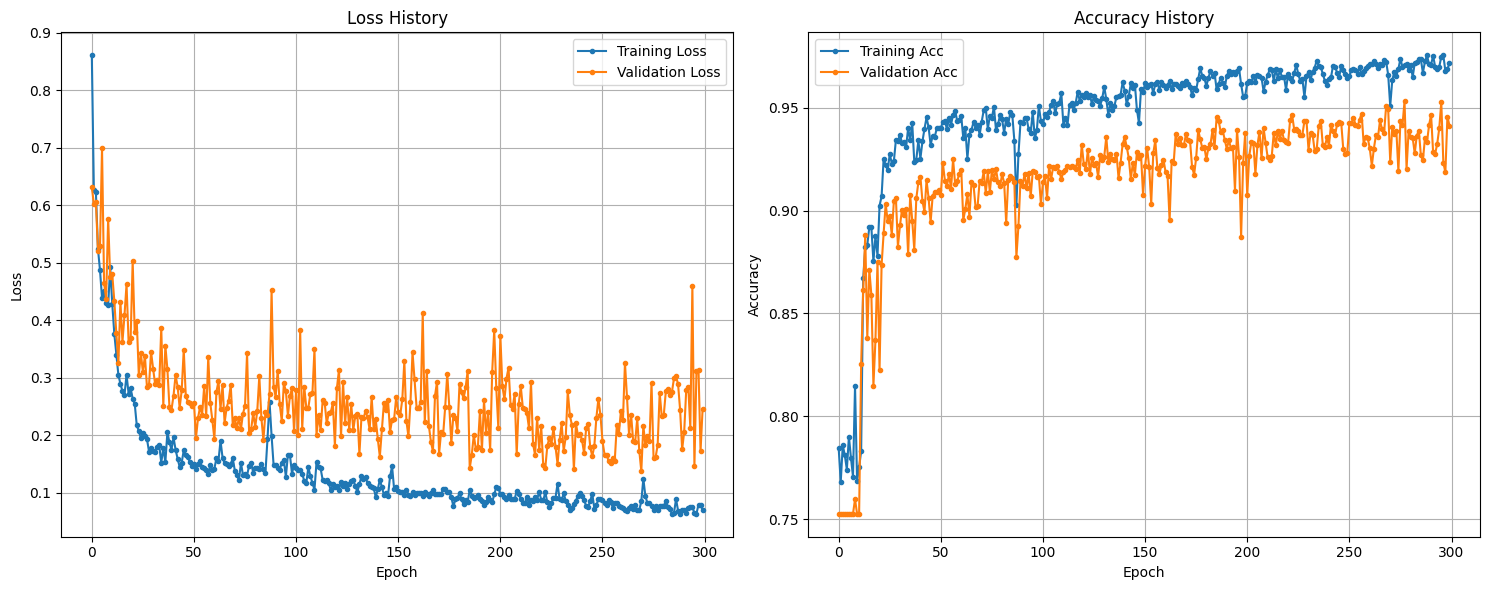

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
#%%time

# 모델 저장 경로
model_path = "./data_semantics/seg_model_unet.pth"

# 모델 생성
model = UNet(input_channels=3, output_channels=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 손실 함수 및 옵티마이저 설정
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003) # 러닝레이트

# 데이터로더 준비
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

def calculate_accuracy(outputs, targets):
    # 출력이 확률값(0~1)이라고 가정하고 0.5를 기준으로 0 또는 1로 변환
    predicted = (outputs > 0.5).float()
    # 정답과 일치하는 픽셀 수 계산
    correct = (predicted == targets).float().sum()
    # 전체 픽셀 수로 나누어 정확도 산출
    accuracy = correct / torch.numel(targets)
    return accuracy.item()

# 기록용 리스트
train_losses = []
val_losses = []
train_accs = []
val_accs = []

# 설정 # 에포크
num_epochs = 300
model_save_dir = "./data_semantics/"
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

# 학습 루프
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    
    for inputs, targets in pbar:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        # 정확도 계산 및 누적
        acc = calculate_accuracy(outputs, targets)
        running_acc += acc
        
        pbar.set_postfix({'loss': loss.item(), 'acc': acc})

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = running_acc / len(train_loader)
    
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)
    
    # Validation (검증)
    model.eval()
    val_running_loss = 0.0
    val_running_acc = 0.0
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets.float())
            
            val_running_loss += loss.item()
            val_running_acc += calculate_accuracy(outputs, targets)
            
    epoch_val_loss = val_running_loss / len(test_loader)
    epoch_val_acc = val_running_acc / len(test_loader)
    
    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Loss: {epoch_train_loss:.4f} (Val: {epoch_val_loss:.4f}) | "
          f"Acc: {epoch_train_acc:.4f} (Val: {epoch_val_acc:.4f})")

    # 10 에포크마다 모델 저장
    if (epoch + 1) % 10 == 0:
        checkpoint_path = f"{model_save_dir}seg_model_unet_epoch_{epoch+1}.pth"
        torch.save(model.state_dict(), checkpoint_path)
        print(f"--> Checkpoint saved: {checkpoint_path}")

# 최종 모델 저장
final_model_path = "./data_semantics/seg_model_unet.pth"
torch.save(model.state_dict(), final_model_path)

# --- 결과 그래프 그리기 (Loss & Accuracy) ---
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. Loss 그래프
axes[0].plot(train_losses, label='Training Loss', marker='.')
axes[0].plot(val_losses, label='Validation Loss', marker='.')
axes[0].set_title('Loss History')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# 2. Accuracy 그래프
axes[1].plot(train_accs, label='Training Acc', marker='.')
axes[1].plot(val_accs, label='Validation Acc', marker='.')
axes[1].set_title('Accuracy History')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# --- 결과 그래프 그리기 (Loss & Accuracy) ---
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. Loss 그래프
axes[0].plot(train_losses, label='Training Loss', marker='.')
axes[0].plot(val_losses, label='Validation Loss', marker='.')
axes[0].set_title('Loss History')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# 2. Accuracy 그래프
axes[1].plot(train_accs, label='Training Acc', marker='.')
axes[1].plot(val_accs, label='Validation Acc', marker='.')
axes[1].set_title('Accuracy History')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# 모델 시각화

In [15]:
model = UNet(input_channels=3, output_channels=1)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()  # 평가 모드로 전환

C:\Users\user\AppData\Local\Temp\ipykernel_27204\2845483008.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=tor

UNet(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc4): Sequential(
    (0): Con

# IoU 계산

In [16]:
import matplotlib.pyplot as plt

def get_output(model, preproc, image_path, output_path):
    # 원본 이미지 로드
    origin_img = imread(image_path)
    data = {"image": origin_img}

    # 전처리 적용
    processed = preproc(**data)
    input_tensor = torch.tensor(processed["image"] / 255.0, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)

    # 모델 추론 (inference)
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)

    # 시그모이드 활성화 후 임계값(0.5) 적용하여 바이너리 마스크 생성
    output = (output[0].squeeze().numpy() > 0.5).astype(np.uint8) * 255   #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)

    # 배경과 결합하여 시각화 (Overlay)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    blended = Image.blend(background, output, alpha=0.5)

    # 변환된 이미지 저장
    blended.save(output_path)

    # PIL 객체를 numpy로 변환
    img_np = np.array(blended)

    # 시각화
    plt.imshow(img_np)
    plt.axis('off')  # 축 제거 (옵션)
    plt.show()

    # blended.show()
    return blended

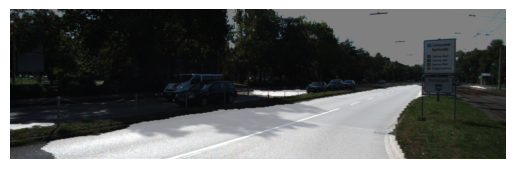

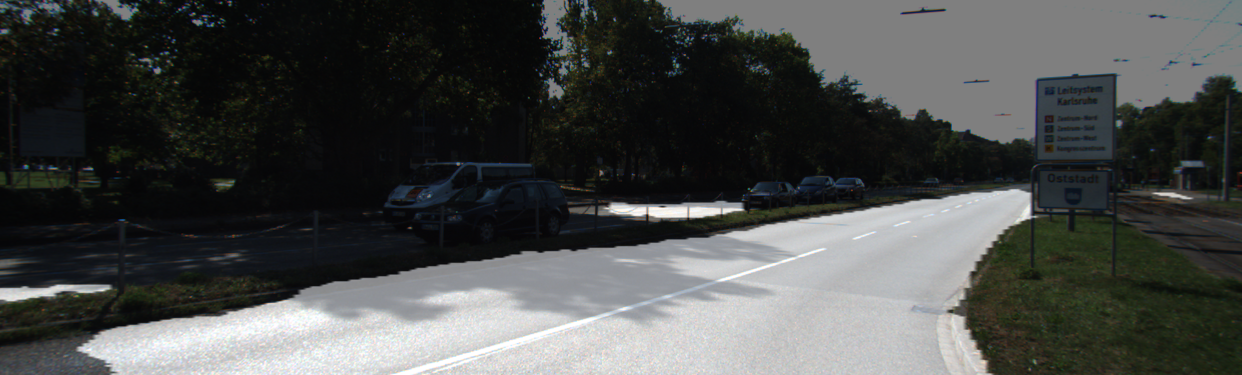

In [17]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다.

get_output(
     model,
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'/result_{str(i).zfill(3)}.png'
 )

In [18]:
def calculate_iou_score(target, prediction):
    if target.shape != prediction.shape:
        prediction = resize(prediction, target.shape, mode='constant', preserve_range=True).astype(np.uint8)

    intersection = np.logical_and(target, prediction).sum() # intersection을 구하는 코드를 작성해주세요.
    union = np.logical_or(target, prediction).sum() # intersection을 구하는 코드를 작성해주세요.
    iou_score = intersection / (union + 1e-7)  # iou 스코어를 구하되 결과값을 float로 만들어주세요!
    print(f"IoU : {iou_score:.6f}")
    return iou_score

In [19]:
def get_output(model, preproc, image_path, output_path, label_path=None):
    origin_img = imread(image_path)
    data = {"image": origin_img}
    processed = preproc(**data)
    input_tensor = torch.tensor(processed["image"] / 255.0, dtype=torch.float32)
    input_tensor = input_tensor.permute(2, 0, 1).unsqueeze(0)

    model.eval()
    with torch.no_grad():
        output = model(input_tensor)

    prediction = (output[0].squeeze().numpy() > 0.5).astype(np.uint8) * 255
    prediction = Image.fromarray(prediction).convert('L')

    background = Image.fromarray(origin_img).convert('RGBA')
    prediction_resized = prediction.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    blended = Image.blend(background, prediction_resized, alpha=0.5)

    blended.save(output_path)
    # PIL 객체를 numpy로 변환
    img_np = np.array(blended)

    # 시각화
    plt.imshow(img_np)
    plt.axis('off')  # 축 제거 (옵션)
    plt.show()

    target = None
    if label_path:
        label_img = imread(label_path)
        label_data = {"image": label_img}
        label_processed = preproc(**label_data)["image"]
        target = (label_processed == 7).astype(np.uint8) * 1

    return blended, np.array(prediction), target

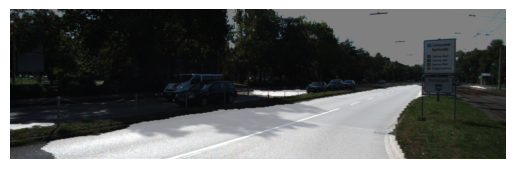

IoU : 0.499784


np.float64(0.4997837236575432)

In [20]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다.
output, prediction, target = get_output(
     model,
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'/result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

U-Net++ 모델도 만들기
- up_block으로 Transpose2D_block 이나 Upsample2D_block 둘중하나 사용
- loss를 binary cross-entropy와 dice coefficient로 사용

# U Net++ 모델 만들기

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# -------------------------------------------------------------------------
# 1. Loss Function 정의 (BCE + Dice)
# -------------------------------------------------------------------------
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        # BCE Loss
        bce_loss = F.binary_cross_entropy(inputs, targets, reduction='mean')
        
        # Dice Loss
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        dice_loss = 1 - dice
        
        # Combined Loss
        return bce_loss + dice_loss

In [22]:
# -------------------------------------------------------------------------
# 2. U-Net++ 모델 정의
# -------------------------------------------------------------------------
class ConvBlock(nn.Module):
    """U-Net의 double_conv와 동일한 역할"""
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels), # 안정적인 학습을 위해 BN 추가 (선택사항, 기존과 맞추려면 제외 가능하나 추천됨)
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNetPlusPlus(nn.Module):
    def __init__(self, input_channels=3, output_channels=1):
        super(UNetPlusPlus, self).__init__()
        
        nb_filter = [64, 128, 256, 512, 1024]
        
        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True) # or nn.ConvTranspose2d

        # ---------------------------
        # Encoder (Backbone)
        # ---------------------------
        self.conv0_0 = ConvBlock(input_channels, nb_filter[0])
        self.conv1_0 = ConvBlock(nb_filter[0], nb_filter[1])
        self.conv2_0 = ConvBlock(nb_filter[1], nb_filter[2])
        self.conv3_0 = ConvBlock(nb_filter[2], nb_filter[3])
        self.conv4_0 = ConvBlock(nb_filter[3], nb_filter[4])

        # ---------------------------
        # Skip Pathways & Decoders
        # ---------------------------
        # X_0_1, X_1_1, X_2_1, X_3_1
        self.conv0_1 = ConvBlock(nb_filter[0]+nb_filter[1], nb_filter[0])
        self.conv1_1 = ConvBlock(nb_filter[1]+nb_filter[2], nb_filter[1])
        self.conv2_1 = ConvBlock(nb_filter[2]+nb_filter[3], nb_filter[2])
        self.conv3_1 = ConvBlock(nb_filter[3]+nb_filter[4], nb_filter[3])

        # X_0_2, X_1_2, X_2_2
        self.conv0_2 = ConvBlock(nb_filter[0]*2+nb_filter[1], nb_filter[0])
        self.conv1_2 = ConvBlock(nb_filter[1]*2+nb_filter[2], nb_filter[1])
        self.conv2_2 = ConvBlock(nb_filter[2]*2+nb_filter[3], nb_filter[2])

        # X_0_3, X_1_3
        self.conv0_3 = ConvBlock(nb_filter[0]*3+nb_filter[1], nb_filter[0])
        self.conv1_3 = ConvBlock(nb_filter[1]*3+nb_filter[2], nb_filter[1])

        # X_0_4
        self.conv0_4 = ConvBlock(nb_filter[0]*4+nb_filter[1], nb_filter[0])

        # Output Layer
        self.final = nn.Conv2d(nb_filter[0], output_channels, kernel_size=1)
        
        # Up-sampling blocks (Using Transpose2D as requested)
        self.up_block1_0 = nn.ConvTranspose2d(nb_filter[1], nb_filter[1], kernel_size=2, stride=2)
        self.up_block2_0 = nn.ConvTranspose2d(nb_filter[2], nb_filter[2], kernel_size=2, stride=2)
        self.up_block3_0 = nn.ConvTranspose2d(nb_filter[3], nb_filter[3], kernel_size=2, stride=2)
        self.up_block4_0 = nn.ConvTranspose2d(nb_filter[4], nb_filter[4], kernel_size=2, stride=2)
        
        self.up_block1_1 = nn.ConvTranspose2d(nb_filter[1], nb_filter[1], kernel_size=2, stride=2)
        self.up_block2_1 = nn.ConvTranspose2d(nb_filter[2], nb_filter[2], kernel_size=2, stride=2)
        self.up_block3_1 = nn.ConvTranspose2d(nb_filter[3], nb_filter[3], kernel_size=2, stride=2)
        
        self.up_block1_2 = nn.ConvTranspose2d(nb_filter[1], nb_filter[1], kernel_size=2, stride=2)
        self.up_block2_2 = nn.ConvTranspose2d(nb_filter[2], nb_filter[2], kernel_size=2, stride=2)
        
        self.up_block1_3 = nn.ConvTranspose2d(nb_filter[1], nb_filter[1], kernel_size=2, stride=2)


    def forward(self, input):
        # Backbone
        x0_0 = self.conv0_0(input)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x2_0 = self.conv2_0(self.pool(x1_0))
        x3_0 = self.conv3_0(self.pool(x2_0))
        x4_0 = self.conv4_0(self.pool(x3_0))

        # Column 1
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up_block1_0(x1_0)], 1))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up_block2_0(x2_0)], 1))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up_block3_0(x3_0)], 1))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up_block4_0(x4_0)], 1))

        # Column 2
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up_block1_1(x1_1)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up_block2_1(x2_1)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up_block3_1(x3_1)], 1))

        # Column 3
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up_block1_2(x1_2)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up_block2_2(x2_2)], 1))

        # Column 4 (Output Column)
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up_block1_3(x1_3)], 1))

        # Output
        output = torch.sigmoid(self.final(x0_4))
        return output

In [ ]:
# -------------------------------------------------------------------------
# 3. 모델 학습 및 평가 (U-Net++ 용)
# -------------------------------------------------------------------------

# 모델 생성 (U-Net++)
model_plus = UNetPlusPlus(input_channels=3, output_channels=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_plus.to(device)

# 손실 함수 (BCE + Dice) 및 옵티마이저 설정
criterion = DiceBCELoss()
optimizer = optim.Adam(model_plus.parameters(), lr=0.003) #러닝레이트

# 저장 경로 설정
model_save_dir = "./data_semantics/"
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

# 기록용 리스트 초기화
train_losses_plus = []
val_losses_plus = []
train_accs_plus = []
val_accs_plus = []

# 학습 루프 (기존 설정과 동일하게 유지)
# num_epochs는 위에서 정의된 변수를 그대로 사용합니다.
print(f"Start Training U-Net++ for {num_epochs} epochs...")

for epoch in range(num_epochs):
    model_plus.train()
    running_loss = 0.0
    running_acc = 0.0
    
    pbar = tqdm(train_loader, desc=f"U-Net++ Epoch {epoch+1}/{num_epochs} [Train]")
    
    for inputs, targets in pbar:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model_plus(inputs)
        loss = criterion(outputs, targets.float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        # 정확도 계산 및 누적
        acc = calculate_accuracy(outputs, targets)
        running_acc += acc
        
        pbar.set_postfix({'loss': loss.item(), 'acc': acc})

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = running_acc / len(train_loader)
    
    train_losses_plus.append(epoch_train_loss)
    train_accs_plus.append(epoch_train_acc)
    
    # Validation (검증)
    model_plus.eval()
    val_running_loss = 0.0
    val_running_acc = 0.0
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model_plus(inputs)
            loss = criterion(outputs, targets.float())
            
            val_running_loss += loss.item()
            val_running_acc += calculate_accuracy(outputs, targets)
            
    epoch_val_loss = val_running_loss / len(test_loader)
    epoch_val_acc = val_running_acc / len(test_loader)
    
    val_losses_plus.append(epoch_val_loss)
    val_accs_plus.append(epoch_val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Loss: {epoch_train_loss:.4f} (Val: {epoch_val_loss:.4f}) | "
          f"Acc: {epoch_train_acc:.4f} (Val: {epoch_val_acc:.4f})")

    # 10 에포크마다 모델 저장
    if (epoch + 1) % 10 == 0:
        checkpoint_path = f"{model_save_dir}seg_model_unetplus_epoch_{epoch+1}.pth"
        torch.save(model_plus.state_dict(), checkpoint_path)
        print(f"--> Checkpoint saved: {checkpoint_path}")

# 최종 모델 저장
final_model_path_plus = "./data_semantics/seg_model_unetplus.pth"
torch.save(model_plus.state_dict(), final_model_path_plus)
print("U-Net++ Training Finished & Model Saved!")

Start Training U-Net++ for 300 epochs...


U-Net++ Epoch 1/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  1.84it/s, loss=0.811, acc=0.904]


Epoch 1/300 | Loss: 1.1728 (Val: 1.7201) | Acc: 0.7172 (Val: 0.3492)


U-Net++ Epoch 2/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.945, acc=0.919]


Epoch 2/300 | Loss: 0.9861 (Val: 4.6916) | Acc: 0.8603 (Val: 0.2477)


U-Net++ Epoch 3/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.751, acc=0.91]


Epoch 3/300 | Loss: 0.8485 (Val: 1.5241) | Acc: 0.8925 (Val: 0.7420)


U-Net++ Epoch 4/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.578, acc=0.936]


Epoch 4/300 | Loss: 0.7099 (Val: 1.1313) | Acc: 0.9159 (Val: 0.7952)


U-Net++ Epoch 5/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.565, acc=0.929]


Epoch 5/300 | Loss: 0.6161 (Val: 0.7609) | Acc: 0.9239 (Val: 0.8837)


U-Net++ Epoch 6/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.04it/s, loss=0.906, acc=0.865]


Epoch 6/300 | Loss: 0.6702 (Val: 0.8196) | Acc: 0.9120 (Val: 0.8650)


U-Net++ Epoch 7/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.808, acc=0.892]


Epoch 7/300 | Loss: 0.6089 (Val: 0.5820) | Acc: 0.9215 (Val: 0.9065)


U-Net++ Epoch 8/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s, loss=0.45, acc=0.933]


Epoch 8/300 | Loss: 0.5262 (Val: 0.5660) | Acc: 0.9221 (Val: 0.9070)


U-Net++ Epoch 9/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.386, acc=0.953]


Epoch 9/300 | Loss: 0.5134 (Val: 0.6532) | Acc: 0.9215 (Val: 0.8940)


U-Net++ Epoch 10/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.416, acc=0.951]


Epoch 10/300 | Loss: 0.4698 (Val: 0.5368) | Acc: 0.9267 (Val: 0.9171)
--> Checkpoint saved: ./data_semantics/seg_model_unetplus_epoch_10.pth


U-Net++ Epoch 11/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.04it/s, loss=0.425, acc=0.929]


Epoch 11/300 | Loss: 0.4558 (Val: 0.7267) | Acc: 0.9320 (Val: 0.8792)


U-Net++ Epoch 12/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.04it/s, loss=0.465, acc=0.917]


Epoch 12/300 | Loss: 0.4345 (Val: 0.5535) | Acc: 0.9332 (Val: 0.9099)


U-Net++ Epoch 13/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  1.97it/s, loss=0.409, acc=0.926]


Epoch 13/300 | Loss: 0.3827 (Val: 0.5043) | Acc: 0.9397 (Val: 0.9175)


U-Net++ Epoch 14/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.399, acc=0.947]


Epoch 14/300 | Loss: 0.4282 (Val: 0.5636) | Acc: 0.9315 (Val: 0.9017)


U-Net++ Epoch 15/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.493, acc=0.929]


Epoch 15/300 | Loss: 0.3928 (Val: 0.5182) | Acc: 0.9360 (Val: 0.9132)


U-Net++ Epoch 16/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.335, acc=0.949]


Epoch 16/300 | Loss: 0.3776 (Val: 0.4729) | Acc: 0.9369 (Val: 0.9194)


U-Net++ Epoch 17/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.552, acc=0.918]


Epoch 17/300 | Loss: 0.3774 (Val: 0.5577) | Acc: 0.9397 (Val: 0.9098)


U-Net++ Epoch 18/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.498, acc=0.915]


Epoch 18/300 | Loss: 0.3568 (Val: 0.5135) | Acc: 0.9387 (Val: 0.9158)


U-Net++ Epoch 19/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.374, acc=0.936]


Epoch 19/300 | Loss: 0.3685 (Val: 0.4108) | Acc: 0.9386 (Val: 0.9304)


U-Net++ Epoch 20/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.385, acc=0.921]


Epoch 20/300 | Loss: 0.3479 (Val: 0.5342) | Acc: 0.9394 (Val: 0.9116)
--> Checkpoint saved: ./data_semantics/seg_model_unetplus_epoch_20.pth


U-Net++ Epoch 21/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.392, acc=0.934]


Epoch 21/300 | Loss: 0.3478 (Val: 0.4754) | Acc: 0.9405 (Val: 0.9146)


U-Net++ Epoch 22/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.04it/s, loss=0.36, acc=0.93] 


Epoch 22/300 | Loss: 0.3721 (Val: 0.5874) | Acc: 0.9359 (Val: 0.9065)


U-Net++ Epoch 23/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.04it/s, loss=0.354, acc=0.927]


Epoch 23/300 | Loss: 0.3578 (Val: 0.5679) | Acc: 0.9373 (Val: 0.9045)


U-Net++ Epoch 24/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.47, acc=0.92]  


Epoch 24/300 | Loss: 0.3875 (Val: 0.4667) | Acc: 0.9316 (Val: 0.9193)


U-Net++ Epoch 25/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.04it/s, loss=0.29, acc=0.952] 


Epoch 25/300 | Loss: 0.3340 (Val: 0.5080) | Acc: 0.9444 (Val: 0.9184)


U-Net++ Epoch 26/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.04it/s, loss=0.306, acc=0.942]


Epoch 26/300 | Loss: 0.3161 (Val: 0.6292) | Acc: 0.9467 (Val: 0.9032)


U-Net++ Epoch 27/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.32, acc=0.941] 


Epoch 27/300 | Loss: 0.3353 (Val: 0.5514) | Acc: 0.9406 (Val: 0.9107)


U-Net++ Epoch 28/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.04it/s, loss=0.289, acc=0.957]


Epoch 28/300 | Loss: 0.3777 (Val: 0.5437) | Acc: 0.9353 (Val: 0.9032)


U-Net++ Epoch 29/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s, loss=0.273, acc=0.952]


Epoch 29/300 | Loss: 0.3649 (Val: 0.4771) | Acc: 0.9361 (Val: 0.9187)


U-Net++ Epoch 30/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.04it/s, loss=0.414, acc=0.911]


Epoch 30/300 | Loss: 0.3309 (Val: 0.4615) | Acc: 0.9400 (Val: 0.9167)
--> Checkpoint saved: ./data_semantics/seg_model_unetplus_epoch_30.pth


U-Net++ Epoch 31/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.361, acc=0.938]


Epoch 31/300 | Loss: 0.2931 (Val: 0.5436) | Acc: 0.9492 (Val: 0.9115)


U-Net++ Epoch 32/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.04it/s, loss=0.243, acc=0.954]


Epoch 32/300 | Loss: 0.2871 (Val: 0.5052) | Acc: 0.9482 (Val: 0.9176)


U-Net++ Epoch 33/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.338, acc=0.954]


Epoch 33/300 | Loss: 0.3760 (Val: 0.5448) | Acc: 0.9324 (Val: 0.9030)


U-Net++ Epoch 34/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.26, acc=0.956] 


Epoch 34/300 | Loss: 0.3462 (Val: 0.5402) | Acc: 0.9380 (Val: 0.9138)


U-Net++ Epoch 35/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.337, acc=0.943]


Epoch 35/300 | Loss: 0.3429 (Val: 0.4970) | Acc: 0.9374 (Val: 0.9190)


U-Net++ Epoch 36/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s, loss=0.235, acc=0.957]


Epoch 36/300 | Loss: 0.3353 (Val: 0.4483) | Acc: 0.9391 (Val: 0.9200)


U-Net++ Epoch 37/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s, loss=0.408, acc=0.923]


Epoch 37/300 | Loss: 0.3272 (Val: 0.4296) | Acc: 0.9409 (Val: 0.9241)


U-Net++ Epoch 38/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.235, acc=0.961]


Epoch 38/300 | Loss: 0.2844 (Val: 0.4908) | Acc: 0.9504 (Val: 0.9190)


U-Net++ Epoch 39/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.288, acc=0.944]


Epoch 39/300 | Loss: 0.2891 (Val: 0.5537) | Acc: 0.9489 (Val: 0.9116)


U-Net++ Epoch 40/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s, loss=0.492, acc=0.916]


Epoch 40/300 | Loss: 0.3074 (Val: 0.4329) | Acc: 0.9447 (Val: 0.9218)
--> Checkpoint saved: ./data_semantics/seg_model_unetplus_epoch_40.pth


U-Net++ Epoch 41/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.158, acc=0.977]


Epoch 41/300 | Loss: 0.2818 (Val: 0.4582) | Acc: 0.9501 (Val: 0.9247)


U-Net++ Epoch 42/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  1.99it/s, loss=0.636, acc=0.881]


Epoch 42/300 | Loss: 0.3395 (Val: 0.4631) | Acc: 0.9366 (Val: 0.9201)


U-Net++ Epoch 43/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.196, acc=0.966]


Epoch 43/300 | Loss: 0.2724 (Val: 0.4237) | Acc: 0.9538 (Val: 0.9230)


U-Net++ Epoch 44/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.373, acc=0.928]


Epoch 44/300 | Loss: 0.3273 (Val: 0.7807) | Acc: 0.9393 (Val: 0.8790)


U-Net++ Epoch 45/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.181, acc=0.97] 


Epoch 45/300 | Loss: 0.2978 (Val: 0.4601) | Acc: 0.9456 (Val: 0.9192)


U-Net++ Epoch 46/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.356, acc=0.933]


Epoch 46/300 | Loss: 0.3213 (Val: 0.4668) | Acc: 0.9413 (Val: 0.9231)


U-Net++ Epoch 47/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.329, acc=0.937]


Epoch 47/300 | Loss: 0.2775 (Val: 0.5140) | Acc: 0.9498 (Val: 0.9203)


U-Net++ Epoch 48/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.302, acc=0.949]


Epoch 48/300 | Loss: 0.2947 (Val: 0.4226) | Acc: 0.9455 (Val: 0.9253)


U-Net++ Epoch 49/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.207, acc=0.971]


Epoch 49/300 | Loss: 0.3138 (Val: 0.3762) | Acc: 0.9453 (Val: 0.9326)


U-Net++ Epoch 50/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.356, acc=0.931]


Epoch 50/300 | Loss: 0.3114 (Val: 0.5197) | Acc: 0.9443 (Val: 0.9146)
--> Checkpoint saved: ./data_semantics/seg_model_unetplus_epoch_50.pth


U-Net++ Epoch 51/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.494, acc=0.904]


Epoch 51/300 | Loss: 0.3185 (Val: 0.5006) | Acc: 0.9419 (Val: 0.9176)


U-Net++ Epoch 52/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.231, acc=0.955]


Epoch 52/300 | Loss: 0.2742 (Val: 0.4551) | Acc: 0.9499 (Val: 0.9192)


U-Net++ Epoch 53/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.346, acc=0.939]


Epoch 53/300 | Loss: 0.2986 (Val: 0.4045) | Acc: 0.9465 (Val: 0.9232)


U-Net++ Epoch 54/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.18, acc=0.972] 


Epoch 54/300 | Loss: 0.2939 (Val: 0.4423) | Acc: 0.9469 (Val: 0.9219)


U-Net++ Epoch 55/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  1.99it/s, loss=0.239, acc=0.952]


Epoch 55/300 | Loss: 0.3171 (Val: 0.4608) | Acc: 0.9442 (Val: 0.9221)


U-Net++ Epoch 56/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.223, acc=0.955]


Epoch 56/300 | Loss: 0.2967 (Val: 0.3130) | Acc: 0.9447 (Val: 0.9472)


U-Net++ Epoch 57/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.38, acc=0.923]


Epoch 57/300 | Loss: 0.3044 (Val: 0.4853) | Acc: 0.9453 (Val: 0.9164)


U-Net++ Epoch 58/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  1.99it/s, loss=0.206, acc=0.961]


Epoch 58/300 | Loss: 0.2928 (Val: 0.4731) | Acc: 0.9457 (Val: 0.9185)


U-Net++ Epoch 59/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.324, acc=0.937]


Epoch 59/300 | Loss: 0.2865 (Val: 0.4213) | Acc: 0.9457 (Val: 0.9215)


U-Net++ Epoch 60/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.195, acc=0.968]


Epoch 60/300 | Loss: 0.2930 (Val: 0.5110) | Acc: 0.9485 (Val: 0.9160)
--> Checkpoint saved: ./data_semantics/seg_model_unetplus_epoch_60.pth


U-Net++ Epoch 61/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.501, acc=0.907]


Epoch 61/300 | Loss: 0.2775 (Val: 0.4333) | Acc: 0.9497 (Val: 0.9252)


U-Net++ Epoch 62/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  1.99it/s, loss=0.46, acc=0.926] 


Epoch 62/300 | Loss: 0.2823 (Val: 0.3657) | Acc: 0.9483 (Val: 0.9333)


U-Net++ Epoch 63/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  1.99it/s, loss=0.186, acc=0.966]


Epoch 63/300 | Loss: 0.2787 (Val: 0.4193) | Acc: 0.9515 (Val: 0.9273)


U-Net++ Epoch 64/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  1.99it/s, loss=0.413, acc=0.935]


Epoch 64/300 | Loss: 0.2767 (Val: 0.3402) | Acc: 0.9492 (Val: 0.9398)


U-Net++ Epoch 65/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  1.99it/s, loss=0.251, acc=0.95] 


Epoch 65/300 | Loss: 0.2719 (Val: 0.5827) | Acc: 0.9519 (Val: 0.9029)


U-Net++ Epoch 66/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.108, acc=0.984]


Epoch 66/300 | Loss: 0.2523 (Val: 0.5186) | Acc: 0.9543 (Val: 0.9116)


U-Net++ Epoch 67/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  1.99it/s, loss=0.169, acc=0.969]


Epoch 67/300 | Loss: 0.2752 (Val: 0.4471) | Acc: 0.9518 (Val: 0.9250)


U-Net++ Epoch 68/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.586, acc=0.91]


Epoch 68/300 | Loss: 0.3119 (Val: 0.4619) | Acc: 0.9448 (Val: 0.9218)


U-Net++ Epoch 69/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.251, acc=0.956]


Epoch 69/300 | Loss: 0.2450 (Val: 0.5651) | Acc: 0.9555 (Val: 0.9078)


U-Net++ Epoch 70/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.226, acc=0.957]


Epoch 70/300 | Loss: 0.2603 (Val: 0.5505) | Acc: 0.9530 (Val: 0.9127)
--> Checkpoint saved: ./data_semantics/seg_model_unetplus_epoch_70.pth


U-Net++ Epoch 71/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.294, acc=0.95] 


Epoch 71/300 | Loss: 0.2861 (Val: 0.4465) | Acc: 0.9473 (Val: 0.9229)


U-Net++ Epoch 72/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.429, acc=0.929]


Epoch 72/300 | Loss: 0.2854 (Val: 0.3563) | Acc: 0.9490 (Val: 0.9318)


U-Net++ Epoch 73/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.241, acc=0.953]


Epoch 73/300 | Loss: 0.2927 (Val: 0.6161) | Acc: 0.9448 (Val: 0.8991)


U-Net++ Epoch 74/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s, loss=0.162, acc=0.971]


Epoch 74/300 | Loss: 0.3119 (Val: 0.4358) | Acc: 0.9439 (Val: 0.9244)


U-Net++ Epoch 75/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s, loss=0.512, acc=0.897]


Epoch 75/300 | Loss: 0.2793 (Val: 0.3765) | Acc: 0.9465 (Val: 0.9318)


U-Net++ Epoch 76/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s, loss=0.332, acc=0.931]


Epoch 76/300 | Loss: 0.3288 (Val: 0.5165) | Acc: 0.9411 (Val: 0.9164)


U-Net++ Epoch 77/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s, loss=0.248, acc=0.95] 


Epoch 77/300 | Loss: 0.2677 (Val: 0.4337) | Acc: 0.9505 (Val: 0.9232)


U-Net++ Epoch 78/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.203, acc=0.968]


Epoch 78/300 | Loss: 0.2822 (Val: 0.4596) | Acc: 0.9485 (Val: 0.9207)


U-Net++ Epoch 79/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.247, acc=0.953]


Epoch 79/300 | Loss: 0.2876 (Val: 0.3867) | Acc: 0.9474 (Val: 0.9352)


U-Net++ Epoch 80/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s, loss=0.228, acc=0.957]


Epoch 80/300 | Loss: 0.2542 (Val: 0.4782) | Acc: 0.9538 (Val: 0.9251)
--> Checkpoint saved: ./data_semantics/seg_model_unetplus_epoch_80.pth


U-Net++ Epoch 81/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s, loss=0.247, acc=0.952]


Epoch 81/300 | Loss: 0.2911 (Val: 0.4465) | Acc: 0.9490 (Val: 0.9222)


U-Net++ Epoch 82/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.171, acc=0.971]


Epoch 82/300 | Loss: 0.2660 (Val: 0.4454) | Acc: 0.9511 (Val: 0.9250)


U-Net++ Epoch 83/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.213, acc=0.96] 


Epoch 83/300 | Loss: 0.2478 (Val: 0.3331) | Acc: 0.9552 (Val: 0.9413)


U-Net++ Epoch 84/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.171, acc=0.975]


Epoch 84/300 | Loss: 0.2452 (Val: 0.4733) | Acc: 0.9579 (Val: 0.9182)


U-Net++ Epoch 85/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.301, acc=0.941]


Epoch 85/300 | Loss: 0.2551 (Val: 0.6230) | Acc: 0.9544 (Val: 0.9102)


U-Net++ Epoch 86/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.276, acc=0.945]


Epoch 86/300 | Loss: 0.2829 (Val: 0.4761) | Acc: 0.9480 (Val: 0.9213)


U-Net++ Epoch 87/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.359, acc=0.938]


Epoch 87/300 | Loss: 0.2972 (Val: 0.4142) | Acc: 0.9464 (Val: 0.9266)


U-Net++ Epoch 88/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.165, acc=0.976]


Epoch 88/300 | Loss: 0.2678 (Val: 0.4388) | Acc: 0.9525 (Val: 0.9263)


U-Net++ Epoch 89/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  1.99it/s, loss=0.469, acc=0.916]


Epoch 89/300 | Loss: 0.2338 (Val: 0.4809) | Acc: 0.9575 (Val: 0.9138)


U-Net++ Epoch 90/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s, loss=0.475, acc=0.923]


Epoch 90/300 | Loss: 0.3011 (Val: 0.4689) | Acc: 0.9480 (Val: 0.9166)
--> Checkpoint saved: ./data_semantics/seg_model_unetplus_epoch_90.pth


U-Net++ Epoch 91/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s, loss=0.332, acc=0.939]


Epoch 91/300 | Loss: 0.2390 (Val: 0.4050) | Acc: 0.9572 (Val: 0.9269)


U-Net++ Epoch 92/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.444, acc=0.938]


Epoch 92/300 | Loss: 0.2612 (Val: 0.4315) | Acc: 0.9524 (Val: 0.9276)


U-Net++ Epoch 93/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.23, acc=0.96]  


Epoch 93/300 | Loss: 0.2510 (Val: 0.5623) | Acc: 0.9540 (Val: 0.9075)


U-Net++ Epoch 94/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.261, acc=0.946]


Epoch 94/300 | Loss: 0.3027 (Val: 0.6623) | Acc: 0.9437 (Val: 0.8966)


U-Net++ Epoch 95/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.222, acc=0.96]


Epoch 95/300 | Loss: 0.2606 (Val: 0.4051) | Acc: 0.9504 (Val: 0.9304)


U-Net++ Epoch 96/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  1.99it/s, loss=0.288, acc=0.952]


Epoch 96/300 | Loss: 0.2739 (Val: 0.3969) | Acc: 0.9507 (Val: 0.9284)


U-Net++ Epoch 97/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.243, acc=0.956]


Epoch 97/300 | Loss: 0.2630 (Val: 0.4490) | Acc: 0.9521 (Val: 0.9281)


U-Net++ Epoch 98/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.208, acc=0.964]


Epoch 98/300 | Loss: 0.2419 (Val: 0.4669) | Acc: 0.9565 (Val: 0.9254)


U-Net++ Epoch 99/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s, loss=0.262, acc=0.95] 


Epoch 99/300 | Loss: 0.2530 (Val: 0.4067) | Acc: 0.9513 (Val: 0.9303)


U-Net++ Epoch 100/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.36, acc=0.934] 


Epoch 100/300 | Loss: 0.2288 (Val: 0.3584) | Acc: 0.9580 (Val: 0.9331)
--> Checkpoint saved: ./data_semantics/seg_model_unetplus_epoch_100.pth


U-Net++ Epoch 101/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.252, acc=0.956]


Epoch 101/300 | Loss: 0.2461 (Val: 0.4803) | Acc: 0.9555 (Val: 0.9189)


U-Net++ Epoch 102/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.26, acc=0.947] 


Epoch 102/300 | Loss: 0.2648 (Val: 0.4870) | Acc: 0.9517 (Val: 0.9212)


U-Net++ Epoch 103/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.149, acc=0.98] 


Epoch 103/300 | Loss: 0.2397 (Val: 0.5247) | Acc: 0.9562 (Val: 0.9158)


U-Net++ Epoch 104/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.269, acc=0.95]


Epoch 104/300 | Loss: 0.2560 (Val: 0.4371) | Acc: 0.9542 (Val: 0.9218)


U-Net++ Epoch 105/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.167, acc=0.971]


Epoch 105/300 | Loss: 0.2329 (Val: 0.4144) | Acc: 0.9567 (Val: 0.9302)


U-Net++ Epoch 106/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.143, acc=0.976]


Epoch 106/300 | Loss: 0.2420 (Val: 0.4004) | Acc: 0.9570 (Val: 0.9322)


U-Net++ Epoch 107/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  1.99it/s, loss=0.154, acc=0.971]


Epoch 107/300 | Loss: 0.2126 (Val: 0.3938) | Acc: 0.9613 (Val: 0.9305)


U-Net++ Epoch 108/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.299, acc=0.938]


Epoch 108/300 | Loss: 0.2657 (Val: 0.3788) | Acc: 0.9521 (Val: 0.9301)


U-Net++ Epoch 109/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.136, acc=0.978]


Epoch 109/300 | Loss: 0.2384 (Val: 0.3561) | Acc: 0.9571 (Val: 0.9419)


U-Net++ Epoch 110/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.181, acc=0.973]


Epoch 110/300 | Loss: 0.2407 (Val: 0.4477) | Acc: 0.9572 (Val: 0.9291)
--> Checkpoint saved: ./data_semantics/seg_model_unetplus_epoch_110.pth


U-Net++ Epoch 111/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s, loss=0.2, acc=0.966]  


Epoch 111/300 | Loss: 0.2605 (Val: 0.5484) | Acc: 0.9534 (Val: 0.9117)


U-Net++ Epoch 112/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.211, acc=0.956]


Epoch 112/300 | Loss: 0.2323 (Val: 0.4211) | Acc: 0.9565 (Val: 0.9259)


U-Net++ Epoch 113/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.578, acc=0.909]


Epoch 113/300 | Loss: 0.2665 (Val: 0.4305) | Acc: 0.9524 (Val: 0.9275)


U-Net++ Epoch 114/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.313, acc=0.938]


Epoch 114/300 | Loss: 0.2524 (Val: 0.4020) | Acc: 0.9544 (Val: 0.9292)


U-Net++ Epoch 115/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.278, acc=0.948]


Epoch 115/300 | Loss: 0.2270 (Val: 0.4822) | Acc: 0.9581 (Val: 0.9184)


U-Net++ Epoch 116/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.479, acc=0.91] 


Epoch 116/300 | Loss: 0.2574 (Val: 0.3296) | Acc: 0.9534 (Val: 0.9421)


U-Net++ Epoch 117/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s, loss=0.184, acc=0.963]


Epoch 117/300 | Loss: 0.2470 (Val: 0.3577) | Acc: 0.9545 (Val: 0.9369)


U-Net++ Epoch 118/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.258, acc=0.951]


Epoch 118/300 | Loss: 0.2471 (Val: 0.4255) | Acc: 0.9561 (Val: 0.9246)


U-Net++ Epoch 119/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.398, acc=0.924]


Epoch 119/300 | Loss: 0.2404 (Val: 0.4228) | Acc: 0.9555 (Val: 0.9296)


U-Net++ Epoch 120/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.243, acc=0.952]


Epoch 120/300 | Loss: 0.2209 (Val: 0.4287) | Acc: 0.9605 (Val: 0.9275)
--> Checkpoint saved: ./data_semantics/seg_model_unetplus_epoch_120.pth


U-Net++ Epoch 121/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s, loss=0.23, acc=0.958] 


Epoch 121/300 | Loss: 0.2190 (Val: 0.4611) | Acc: 0.9598 (Val: 0.9202)


U-Net++ Epoch 122/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.328, acc=0.935]


Epoch 122/300 | Loss: 0.2317 (Val: 0.5121) | Acc: 0.9574 (Val: 0.9133)


U-Net++ Epoch 123/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.04it/s, loss=0.278, acc=0.949]


Epoch 123/300 | Loss: 0.2682 (Val: 0.4565) | Acc: 0.9548 (Val: 0.9287)


U-Net++ Epoch 124/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.04it/s, loss=0.533, acc=0.925]


Epoch 124/300 | Loss: 0.2521 (Val: 0.4826) | Acc: 0.9549 (Val: 0.9197)


U-Net++ Epoch 125/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.235, acc=0.957]


Epoch 125/300 | Loss: 0.2518 (Val: 0.5995) | Acc: 0.9526 (Val: 0.9070)


U-Net++ Epoch 126/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.158, acc=0.973]


Epoch 126/300 | Loss: 0.2471 (Val: 0.3992) | Acc: 0.9555 (Val: 0.9343)


U-Net++ Epoch 127/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.186, acc=0.961]


Epoch 127/300 | Loss: 0.2297 (Val: 0.4875) | Acc: 0.9590 (Val: 0.9242)


U-Net++ Epoch 128/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.293, acc=0.954]


Epoch 128/300 | Loss: 0.2228 (Val: 0.5195) | Acc: 0.9594 (Val: 0.9227)


U-Net++ Epoch 129/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s, loss=0.16, acc=0.974] 


Epoch 129/300 | Loss: 0.2060 (Val: 0.4813) | Acc: 0.9625 (Val: 0.9229)


U-Net++ Epoch 130/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.0945, acc=0.985]


Epoch 130/300 | Loss: 0.2033 (Val: 0.3453) | Acc: 0.9635 (Val: 0.9391)
--> Checkpoint saved: ./data_semantics/seg_model_unetplus_epoch_130.pth


U-Net++ Epoch 131/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.255, acc=0.948]


Epoch 131/300 | Loss: 0.2292 (Val: 0.2936) | Acc: 0.9580 (Val: 0.9466)


U-Net++ Epoch 132/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.197, acc=0.973]


Epoch 132/300 | Loss: 0.2132 (Val: 0.3816) | Acc: 0.9617 (Val: 0.9370)


U-Net++ Epoch 133/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.137, acc=0.978]


Epoch 133/300 | Loss: 0.2247 (Val: 0.5261) | Acc: 0.9603 (Val: 0.9149)


U-Net++ Epoch 134/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.272, acc=0.947]


Epoch 134/300 | Loss: 0.2363 (Val: 0.5065) | Acc: 0.9577 (Val: 0.9216)


U-Net++ Epoch 135/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.232, acc=0.952]


Epoch 135/300 | Loss: 0.2269 (Val: 0.3933) | Acc: 0.9586 (Val: 0.9311)


U-Net++ Epoch 136/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.203, acc=0.963]


Epoch 136/300 | Loss: 0.2656 (Val: 0.4209) | Acc: 0.9535 (Val: 0.9238)


U-Net++ Epoch 137/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s, loss=0.182, acc=0.966]


Epoch 137/300 | Loss: 0.2266 (Val: 0.4840) | Acc: 0.9577 (Val: 0.9240)


U-Net++ Epoch 138/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.479, acc=0.931]


Epoch 138/300 | Loss: 0.2483 (Val: 0.4149) | Acc: 0.9564 (Val: 0.9313)


U-Net++ Epoch 139/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.222, acc=0.957]


Epoch 139/300 | Loss: 0.2300 (Val: 0.4775) | Acc: 0.9582 (Val: 0.9191)


U-Net++ Epoch 140/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.189, acc=0.97] 


Epoch 140/300 | Loss: 0.2268 (Val: 0.5060) | Acc: 0.9603 (Val: 0.9218)
--> Checkpoint saved: ./data_semantics/seg_model_unetplus_epoch_140.pth


U-Net++ Epoch 141/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.192, acc=0.965]


Epoch 141/300 | Loss: 0.2183 (Val: 0.3855) | Acc: 0.9592 (Val: 0.9324)


U-Net++ Epoch 142/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.441, acc=0.925]


Epoch 142/300 | Loss: 0.2378 (Val: 0.3171) | Acc: 0.9562 (Val: 0.9426)


U-Net++ Epoch 143/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.355, acc=0.943]


Epoch 143/300 | Loss: 0.2131 (Val: 0.4256) | Acc: 0.9619 (Val: 0.9324)


U-Net++ Epoch 144/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.116, acc=0.98] 


Epoch 144/300 | Loss: 0.2018 (Val: 0.4081) | Acc: 0.9635 (Val: 0.9377)


U-Net++ Epoch 145/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.158, acc=0.974]


Epoch 145/300 | Loss: 0.2388 (Val: 0.4035) | Acc: 0.9569 (Val: 0.9360)


U-Net++ Epoch 146/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.278, acc=0.946]


Epoch 146/300 | Loss: 0.2156 (Val: 0.3125) | Acc: 0.9590 (Val: 0.9454)


U-Net++ Epoch 147/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.188, acc=0.964]


Epoch 147/300 | Loss: 0.2229 (Val: 0.5069) | Acc: 0.9591 (Val: 0.9203)


U-Net++ Epoch 148/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s, loss=0.229, acc=0.963]


Epoch 148/300 | Loss: 0.2502 (Val: 0.3765) | Acc: 0.9558 (Val: 0.9383)


U-Net++ Epoch 149/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.209, acc=0.959]


Epoch 149/300 | Loss: 0.2264 (Val: 0.4010) | Acc: 0.9596 (Val: 0.9268)


U-Net++ Epoch 150/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.234, acc=0.956]


Epoch 150/300 | Loss: 0.2592 (Val: 0.3546) | Acc: 0.9537 (Val: 0.9340)
--> Checkpoint saved: ./data_semantics/seg_model_unetplus_epoch_150.pth


U-Net++ Epoch 151/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s, loss=0.163, acc=0.972]


Epoch 151/300 | Loss: 0.2275 (Val: 0.4100) | Acc: 0.9591 (Val: 0.9281)


U-Net++ Epoch 152/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s, loss=0.138, acc=0.976]


Epoch 152/300 | Loss: 0.2118 (Val: 0.4423) | Acc: 0.9636 (Val: 0.9257)


U-Net++ Epoch 153/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.217, acc=0.96] 


Epoch 153/300 | Loss: 0.2026 (Val: 0.4228) | Acc: 0.9628 (Val: 0.9315)


U-Net++ Epoch 154/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.04it/s, loss=0.394, acc=0.934]


Epoch 154/300 | Loss: 0.2158 (Val: 0.4136) | Acc: 0.9609 (Val: 0.9360)


U-Net++ Epoch 155/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s, loss=0.194, acc=0.965]


Epoch 155/300 | Loss: 0.1887 (Val: 0.4742) | Acc: 0.9655 (Val: 0.9271)


U-Net++ Epoch 156/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.208, acc=0.963]


Epoch 156/300 | Loss: 0.1969 (Val: 0.3839) | Acc: 0.9645 (Val: 0.9389)


U-Net++ Epoch 157/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.204, acc=0.958]


Epoch 157/300 | Loss: 0.1826 (Val: 0.5076) | Acc: 0.9672 (Val: 0.9234)


U-Net++ Epoch 158/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.134, acc=0.98]


Epoch 158/300 | Loss: 0.2373 (Val: 0.4478) | Acc: 0.9578 (Val: 0.9277)


U-Net++ Epoch 159/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.208, acc=0.969]


Epoch 159/300 | Loss: 0.2091 (Val: 0.3159) | Acc: 0.9614 (Val: 0.9438)


U-Net++ Epoch 160/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.238, acc=0.96] 


Epoch 160/300 | Loss: 0.2092 (Val: 0.2842) | Acc: 0.9618 (Val: 0.9496)
--> Checkpoint saved: ./data_semantics/seg_model_unetplus_epoch_160.pth


U-Net++ Epoch 161/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.169, acc=0.97] 


Epoch 161/300 | Loss: 0.1895 (Val: 0.4159) | Acc: 0.9667 (Val: 0.9371)


U-Net++ Epoch 162/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  1.99it/s, loss=0.166, acc=0.971]


Epoch 162/300 | Loss: 0.2374 (Val: 0.4928) | Acc: 0.9592 (Val: 0.9244)


U-Net++ Epoch 163/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.13, acc=0.979] 


Epoch 163/300 | Loss: 0.1828 (Val: 0.4906) | Acc: 0.9658 (Val: 0.9268)


U-Net++ Epoch 164/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s, loss=0.194, acc=0.966]


Epoch 164/300 | Loss: 0.2074 (Val: 0.4409) | Acc: 0.9629 (Val: 0.9278)


U-Net++ Epoch 165/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.148, acc=0.972]


Epoch 165/300 | Loss: 0.2042 (Val: 0.3917) | Acc: 0.9644 (Val: 0.9369)


U-Net++ Epoch 166/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s, loss=0.165, acc=0.973]


Epoch 166/300 | Loss: 0.1834 (Val: 0.4523) | Acc: 0.9666 (Val: 0.9291)


U-Net++ Epoch 167/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s, loss=0.454, acc=0.939]


Epoch 167/300 | Loss: 0.2314 (Val: 0.2916) | Acc: 0.9615 (Val: 0.9470)


U-Net++ Epoch 168/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.195, acc=0.967]


Epoch 168/300 | Loss: 0.2039 (Val: 0.3420) | Acc: 0.9643 (Val: 0.9416)


U-Net++ Epoch 169/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.205, acc=0.97] 


Epoch 169/300 | Loss: 0.2428 (Val: 0.4339) | Acc: 0.9578 (Val: 0.9239)


U-Net++ Epoch 170/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.377, acc=0.939]


Epoch 170/300 | Loss: 0.2600 (Val: 0.4728) | Acc: 0.9560 (Val: 0.9210)
--> Checkpoint saved: ./data_semantics/seg_model_unetplus_epoch_170.pth


U-Net++ Epoch 171/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  1.98it/s, loss=0.245, acc=0.958]


Epoch 171/300 | Loss: 0.2368 (Val: 0.3285) | Acc: 0.9567 (Val: 0.9358)


U-Net++ Epoch 172/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  1.98it/s, loss=0.0931, acc=0.988]


Epoch 172/300 | Loss: 0.2229 (Val: 0.3315) | Acc: 0.9604 (Val: 0.9370)


U-Net++ Epoch 173/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.04it/s, loss=0.239, acc=0.961]


Epoch 173/300 | Loss: 0.2078 (Val: 0.3599) | Acc: 0.9626 (Val: 0.9335)


U-Net++ Epoch 174/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.232, acc=0.966]


Epoch 174/300 | Loss: 0.2036 (Val: 0.2701) | Acc: 0.9630 (Val: 0.9521)


U-Net++ Epoch 175/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.247, acc=0.957]


Epoch 175/300 | Loss: 0.1987 (Val: 0.2507) | Acc: 0.9636 (Val: 0.9530)


U-Net++ Epoch 176/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.21, acc=0.966] 


Epoch 176/300 | Loss: 0.2222 (Val: 0.3460) | Acc: 0.9596 (Val: 0.9372)


U-Net++ Epoch 177/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.199, acc=0.966]


Epoch 177/300 | Loss: 0.1942 (Val: 0.2745) | Acc: 0.9657 (Val: 0.9495)


U-Net++ Epoch 178/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  1.97it/s, loss=0.218, acc=0.96] 


Epoch 178/300 | Loss: 0.1913 (Val: 0.5212) | Acc: 0.9655 (Val: 0.9214)


U-Net++ Epoch 179/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.35, acc=0.939] 


Epoch 179/300 | Loss: 0.1949 (Val: 0.5080) | Acc: 0.9652 (Val: 0.9285)


U-Net++ Epoch 180/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.215, acc=0.959]


Epoch 180/300 | Loss: 0.2260 (Val: 0.2612) | Acc: 0.9603 (Val: 0.9549)
--> Checkpoint saved: ./data_semantics/seg_model_unetplus_epoch_180.pth


U-Net++ Epoch 181/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.04it/s, loss=0.367, acc=0.936]


Epoch 181/300 | Loss: 0.2087 (Val: 0.3652) | Acc: 0.9628 (Val: 0.9365)


U-Net++ Epoch 182/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.411, acc=0.936]


Epoch 182/300 | Loss: 0.1931 (Val: 0.3807) | Acc: 0.9663 (Val: 0.9337)


U-Net++ Epoch 183/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.04it/s, loss=0.134, acc=0.978]


Epoch 183/300 | Loss: 0.1718 (Val: 0.3309) | Acc: 0.9689 (Val: 0.9428)


U-Net++ Epoch 184/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.04it/s, loss=0.151, acc=0.97] 


Epoch 184/300 | Loss: 0.2007 (Val: 0.3791) | Acc: 0.9631 (Val: 0.9423)


U-Net++ Epoch 185/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.363, acc=0.945]


Epoch 185/300 | Loss: 0.2295 (Val: 0.3705) | Acc: 0.9578 (Val: 0.9385)


U-Net++ Epoch 186/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.04it/s, loss=0.202, acc=0.968]


Epoch 186/300 | Loss: 0.1800 (Val: 0.3465) | Acc: 0.9692 (Val: 0.9381)


U-Net++ Epoch 187/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.22, acc=0.962] 


Epoch 187/300 | Loss: 0.1966 (Val: 0.2604) | Acc: 0.9652 (Val: 0.9529)


U-Net++ Epoch 188/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.282, acc=0.946]


Epoch 188/300 | Loss: 0.1919 (Val: 0.3052) | Acc: 0.9643 (Val: 0.9460)


U-Net++ Epoch 189/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s, loss=0.113, acc=0.978]


Epoch 189/300 | Loss: 0.1651 (Val: 0.4108) | Acc: 0.9696 (Val: 0.9296)


U-Net++ Epoch 190/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.11, acc=0.981] 


Epoch 190/300 | Loss: 0.1569 (Val: 0.4075) | Acc: 0.9717 (Val: 0.9337)
--> Checkpoint saved: ./data_semantics/seg_model_unetplus_epoch_190.pth


U-Net++ Epoch 191/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.134, acc=0.977]


Epoch 191/300 | Loss: 0.1809 (Val: 0.3379) | Acc: 0.9667 (Val: 0.9431)


U-Net++ Epoch 192/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.279, acc=0.948]


Epoch 192/300 | Loss: 0.2148 (Val: 0.3751) | Acc: 0.9616 (Val: 0.9405)


U-Net++ Epoch 193/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.04it/s, loss=0.132, acc=0.977]


Epoch 193/300 | Loss: 0.1995 (Val: 0.3526) | Acc: 0.9643 (Val: 0.9439)


U-Net++ Epoch 194/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.263, acc=0.955]


Epoch 194/300 | Loss: 0.2514 (Val: 0.2598) | Acc: 0.9552 (Val: 0.9539)


U-Net++ Epoch 195/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.182, acc=0.967]


Epoch 195/300 | Loss: 0.1743 (Val: 0.2468) | Acc: 0.9683 (Val: 0.9539)


U-Net++ Epoch 196/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.2, acc=0.964]  


Epoch 196/300 | Loss: 0.1722 (Val: 0.3875) | Acc: 0.9686 (Val: 0.9374)


U-Net++ Epoch 197/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.04it/s, loss=0.214, acc=0.957]


Epoch 197/300 | Loss: 0.1810 (Val: 0.3933) | Acc: 0.9666 (Val: 0.9383)


U-Net++ Epoch 198/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.218, acc=0.955]


Epoch 198/300 | Loss: 0.1915 (Val: 0.5277) | Acc: 0.9650 (Val: 0.9122)


U-Net++ Epoch 199/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.119, acc=0.98] 


Epoch 199/300 | Loss: 0.1757 (Val: 0.3914) | Acc: 0.9674 (Val: 0.9387)


U-Net++ Epoch 200/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.252, acc=0.954]


Epoch 200/300 | Loss: 0.1922 (Val: 0.3620) | Acc: 0.9654 (Val: 0.9402)
--> Checkpoint saved: ./data_semantics/seg_model_unetplus_epoch_200.pth


U-Net++ Epoch 201/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.04it/s, loss=0.174, acc=0.965]


Epoch 201/300 | Loss: 0.1850 (Val: 0.2439) | Acc: 0.9669 (Val: 0.9552)


U-Net++ Epoch 202/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.127, acc=0.977]


Epoch 202/300 | Loss: 0.1800 (Val: 0.2440) | Acc: 0.9682 (Val: 0.9559)


U-Net++ Epoch 203/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.248, acc=0.952]


Epoch 203/300 | Loss: 0.1651 (Val: 0.2541) | Acc: 0.9694 (Val: 0.9550)


U-Net++ Epoch 204/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.14, acc=0.976] 


Epoch 204/300 | Loss: 0.2113 (Val: 0.3628) | Acc: 0.9617 (Val: 0.9369)


U-Net++ Epoch 205/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.227, acc=0.958]


Epoch 205/300 | Loss: 0.2022 (Val: 0.2599) | Acc: 0.9635 (Val: 0.9536)


U-Net++ Epoch 206/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s, loss=0.196, acc=0.966]


Epoch 206/300 | Loss: 0.1860 (Val: 0.4890) | Acc: 0.9662 (Val: 0.9192)


U-Net++ Epoch 207/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  1.98it/s, loss=0.281, acc=0.948]


Epoch 207/300 | Loss: 0.1671 (Val: 0.4470) | Acc: 0.9690 (Val: 0.9265)


U-Net++ Epoch 208/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.105, acc=0.98] 


Epoch 208/300 | Loss: 0.1619 (Val: 0.2633) | Acc: 0.9699 (Val: 0.9534)


U-Net++ Epoch 209/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s, loss=0.117, acc=0.98] 


Epoch 209/300 | Loss: 0.1815 (Val: 0.2785) | Acc: 0.9677 (Val: 0.9505)


U-Net++ Epoch 210/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.0963, acc=0.983]


Epoch 210/300 | Loss: 0.1736 (Val: 0.3065) | Acc: 0.9687 (Val: 0.9438)
--> Checkpoint saved: ./data_semantics/seg_model_unetplus_epoch_210.pth


U-Net++ Epoch 211/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.157, acc=0.968]


Epoch 211/300 | Loss: 0.2233 (Val: 0.3950) | Acc: 0.9608 (Val: 0.9297)


U-Net++ Epoch 212/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  1.99it/s, loss=0.259, acc=0.961]


Epoch 212/300 | Loss: 0.1840 (Val: 0.3278) | Acc: 0.9678 (Val: 0.9411)


U-Net++ Epoch 213/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.142, acc=0.975]


Epoch 213/300 | Loss: 0.1620 (Val: 0.3204) | Acc: 0.9708 (Val: 0.9452)


U-Net++ Epoch 214/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.15, acc=0.973] 


Epoch 214/300 | Loss: 0.1668 (Val: 0.4450) | Acc: 0.9697 (Val: 0.9287)


U-Net++ Epoch 215/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.162, acc=0.975]


Epoch 215/300 | Loss: 0.1427 (Val: 0.2947) | Acc: 0.9744 (Val: 0.9507)


U-Net++ Epoch 216/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.112, acc=0.983]


Epoch 216/300 | Loss: 0.1459 (Val: 0.3068) | Acc: 0.9744 (Val: 0.9457)


U-Net++ Epoch 217/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s, loss=0.133, acc=0.978]


Epoch 217/300 | Loss: 0.1585 (Val: 0.2843) | Acc: 0.9710 (Val: 0.9489)


U-Net++ Epoch 218/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.136, acc=0.974]


Epoch 218/300 | Loss: 0.1735 (Val: 0.3503) | Acc: 0.9686 (Val: 0.9428)


U-Net++ Epoch 219/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.224, acc=0.961]


Epoch 219/300 | Loss: 0.1885 (Val: 0.4591) | Acc: 0.9671 (Val: 0.9290)


U-Net++ Epoch 220/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.181, acc=0.968]


Epoch 220/300 | Loss: 0.2041 (Val: 0.4356) | Acc: 0.9645 (Val: 0.9278)
--> Checkpoint saved: ./data_semantics/seg_model_unetplus_epoch_220.pth


U-Net++ Epoch 221/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.152, acc=0.969]


Epoch 221/300 | Loss: 0.1609 (Val: 0.3728) | Acc: 0.9709 (Val: 0.9384)


U-Net++ Epoch 222/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.165, acc=0.969]


Epoch 222/300 | Loss: 0.1730 (Val: 0.4512) | Acc: 0.9689 (Val: 0.9267)


U-Net++ Epoch 223/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.163, acc=0.974]


Epoch 223/300 | Loss: 0.1733 (Val: 0.2902) | Acc: 0.9685 (Val: 0.9508)


U-Net++ Epoch 224/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s, loss=0.117, acc=0.981]


Epoch 224/300 | Loss: 0.1630 (Val: 0.3339) | Acc: 0.9701 (Val: 0.9433)


U-Net++ Epoch 225/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s, loss=0.308, acc=0.942]


Epoch 225/300 | Loss: 0.1891 (Val: 0.2656) | Acc: 0.9649 (Val: 0.9539)


U-Net++ Epoch 226/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.191, acc=0.962]


Epoch 226/300 | Loss: 0.1629 (Val: 0.4306) | Acc: 0.9710 (Val: 0.9311)


U-Net++ Epoch 227/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.115, acc=0.977]


Epoch 227/300 | Loss: 0.1858 (Val: 0.3266) | Acc: 0.9652 (Val: 0.9444)


U-Net++ Epoch 228/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s, loss=0.397, acc=0.944]


Epoch 228/300 | Loss: 0.2001 (Val: 0.3261) | Acc: 0.9643 (Val: 0.9444)


U-Net++ Epoch 229/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s, loss=0.139, acc=0.973]


Epoch 229/300 | Loss: 0.1956 (Val: 0.4074) | Acc: 0.9636 (Val: 0.9263)


U-Net++ Epoch 230/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.153, acc=0.973]


Epoch 230/300 | Loss: 0.1604 (Val: 0.2686) | Acc: 0.9705 (Val: 0.9533)
--> Checkpoint saved: ./data_semantics/seg_model_unetplus_epoch_230.pth


U-Net++ Epoch 231/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s, loss=0.18, acc=0.967]


Epoch 231/300 | Loss: 0.1826 (Val: 0.3123) | Acc: 0.9668 (Val: 0.9476)


U-Net++ Epoch 232/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.239, acc=0.955]


Epoch 232/300 | Loss: 0.2115 (Val: 0.4033) | Acc: 0.9637 (Val: 0.9324)


U-Net++ Epoch 233/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.201, acc=0.965]


Epoch 233/300 | Loss: 0.2062 (Val: 0.5028) | Acc: 0.9637 (Val: 0.9191)


U-Net++ Epoch 234/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.184, acc=0.969]


Epoch 234/300 | Loss: 0.1825 (Val: 0.5357) | Acc: 0.9667 (Val: 0.9217)


U-Net++ Epoch 235/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.117, acc=0.985]


Epoch 235/300 | Loss: 0.1850 (Val: 0.5087) | Acc: 0.9681 (Val: 0.9196)


U-Net++ Epoch 236/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.447, acc=0.931]


Epoch 236/300 | Loss: 0.1966 (Val: 0.3316) | Acc: 0.9645 (Val: 0.9434)


U-Net++ Epoch 237/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s, loss=0.194, acc=0.968]


Epoch 237/300 | Loss: 0.1831 (Val: 0.4970) | Acc: 0.9674 (Val: 0.9176)


U-Net++ Epoch 238/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.424, acc=0.943]


Epoch 238/300 | Loss: 0.1869 (Val: 0.2615) | Acc: 0.9673 (Val: 0.9550)


U-Net++ Epoch 239/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  1.99it/s, loss=0.337, acc=0.935]


Epoch 239/300 | Loss: 0.2197 (Val: 0.3804) | Acc: 0.9587 (Val: 0.9349)


U-Net++ Epoch 240/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s, loss=0.178, acc=0.969]


Epoch 240/300 | Loss: 0.1683 (Val: 0.3151) | Acc: 0.9694 (Val: 0.9476)
--> Checkpoint saved: ./data_semantics/seg_model_unetplus_epoch_240.pth


U-Net++ Epoch 241/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s, loss=0.139, acc=0.976]


Epoch 241/300 | Loss: 0.1653 (Val: 0.3043) | Acc: 0.9696 (Val: 0.9470)


U-Net++ Epoch 242/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  1.99it/s, loss=0.165, acc=0.969]


Epoch 242/300 | Loss: 0.1655 (Val: 0.2707) | Acc: 0.9704 (Val: 0.9505)


U-Net++ Epoch 243/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.194, acc=0.966]


Epoch 243/300 | Loss: 0.1754 (Val: 0.2467) | Acc: 0.9682 (Val: 0.9559)


U-Net++ Epoch 244/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.114, acc=0.981]


Epoch 244/300 | Loss: 0.1774 (Val: 0.2668) | Acc: 0.9696 (Val: 0.9525)


U-Net++ Epoch 245/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.14, acc=0.975] 


Epoch 245/300 | Loss: 0.2189 (Val: 0.4064) | Acc: 0.9601 (Val: 0.9290)


U-Net++ Epoch 246/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.151, acc=0.971]


Epoch 246/300 | Loss: 0.1760 (Val: 0.3779) | Acc: 0.9695 (Val: 0.9324)


U-Net++ Epoch 247/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s, loss=0.154, acc=0.974]


Epoch 247/300 | Loss: 0.1563 (Val: 0.2661) | Acc: 0.9726 (Val: 0.9518)


U-Net++ Epoch 248/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.14, acc=0.976] 


Epoch 248/300 | Loss: 0.1626 (Val: 0.2290) | Acc: 0.9715 (Val: 0.9602)


U-Net++ Epoch 249/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.142, acc=0.975]


Epoch 249/300 | Loss: 0.1558 (Val: 0.4122) | Acc: 0.9718 (Val: 0.9339)


U-Net++ Epoch 250/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  1.99it/s, loss=0.158, acc=0.974]


Epoch 250/300 | Loss: 0.1635 (Val: 0.2900) | Acc: 0.9703 (Val: 0.9508)
--> Checkpoint saved: ./data_semantics/seg_model_unetplus_epoch_250.pth


U-Net++ Epoch 251/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.324, acc=0.952]


Epoch 251/300 | Loss: 0.1894 (Val: 0.2389) | Acc: 0.9670 (Val: 0.9590)


U-Net++ Epoch 252/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.229, acc=0.956]


Epoch 252/300 | Loss: 0.1774 (Val: 0.3781) | Acc: 0.9691 (Val: 0.9375)


U-Net++ Epoch 253/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.236, acc=0.959]


Epoch 253/300 | Loss: 0.2034 (Val: 0.3954) | Acc: 0.9629 (Val: 0.9410)


U-Net++ Epoch 254/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.18, acc=0.963] 


Epoch 254/300 | Loss: 0.1868 (Val: 0.4077) | Acc: 0.9667 (Val: 0.9331)


U-Net++ Epoch 255/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.131, acc=0.975]


Epoch 255/300 | Loss: 0.2002 (Val: 0.2403) | Acc: 0.9634 (Val: 0.9585)


U-Net++ Epoch 256/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.189, acc=0.966]


Epoch 256/300 | Loss: 0.1918 (Val: 0.2673) | Acc: 0.9652 (Val: 0.9513)


U-Net++ Epoch 257/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.137, acc=0.973]


Epoch 257/300 | Loss: 0.1885 (Val: 0.3208) | Acc: 0.9660 (Val: 0.9441)


U-Net++ Epoch 258/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.0871, acc=0.986]


Epoch 258/300 | Loss: 0.1633 (Val: 0.3439) | Acc: 0.9704 (Val: 0.9401)


U-Net++ Epoch 259/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s, loss=0.145, acc=0.971]


Epoch 259/300 | Loss: 0.1734 (Val: 0.3495) | Acc: 0.9693 (Val: 0.9433)


U-Net++ Epoch 260/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.16, acc=0.975]


Epoch 260/300 | Loss: 0.1613 (Val: 0.4269) | Acc: 0.9719 (Val: 0.9310)
--> Checkpoint saved: ./data_semantics/seg_model_unetplus_epoch_260.pth


U-Net++ Epoch 261/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.132, acc=0.978]


Epoch 261/300 | Loss: 0.1418 (Val: 0.2789) | Acc: 0.9750 (Val: 0.9516)


U-Net++ Epoch 262/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  1.99it/s, loss=0.136, acc=0.974]


Epoch 262/300 | Loss: 0.1811 (Val: 0.4244) | Acc: 0.9680 (Val: 0.9317)


U-Net++ Epoch 263/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.217, acc=0.959]


Epoch 263/300 | Loss: 0.1860 (Val: 0.4404) | Acc: 0.9666 (Val: 0.9317)


U-Net++ Epoch 264/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s, loss=0.145, acc=0.975]


Epoch 264/300 | Loss: 0.1620 (Val: 0.3479) | Acc: 0.9701 (Val: 0.9436)


U-Net++ Epoch 265/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.151, acc=0.978]


Epoch 265/300 | Loss: 0.1709 (Val: 0.3380) | Acc: 0.9721 (Val: 0.9481)


U-Net++ Epoch 266/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s, loss=0.101, acc=0.982]


Epoch 266/300 | Loss: 0.1424 (Val: 0.3973) | Acc: 0.9740 (Val: 0.9422)


U-Net++ Epoch 267/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.174, acc=0.968]


Epoch 267/300 | Loss: 0.1823 (Val: 0.3337) | Acc: 0.9672 (Val: 0.9444)


U-Net++ Epoch 268/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.0864, acc=0.984]


Epoch 268/300 | Loss: 0.1658 (Val: 0.4357) | Acc: 0.9691 (Val: 0.9337)


U-Net++ Epoch 269/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.155, acc=0.969]


Epoch 269/300 | Loss: 0.1746 (Val: 0.3145) | Acc: 0.9681 (Val: 0.9497)


U-Net++ Epoch 270/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.156, acc=0.968]


Epoch 270/300 | Loss: 0.1516 (Val: 0.3695) | Acc: 0.9728 (Val: 0.9418)
--> Checkpoint saved: ./data_semantics/seg_model_unetplus_epoch_270.pth


U-Net++ Epoch 271/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s, loss=0.158, acc=0.974]


Epoch 271/300 | Loss: 0.1467 (Val: 0.3089) | Acc: 0.9737 (Val: 0.9485)


U-Net++ Epoch 272/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.115, acc=0.977]


Epoch 272/300 | Loss: 0.1337 (Val: 0.3555) | Acc: 0.9766 (Val: 0.9402)


U-Net++ Epoch 273/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.133, acc=0.977]


Epoch 273/300 | Loss: 0.1628 (Val: 0.3522) | Acc: 0.9707 (Val: 0.9443)


U-Net++ Epoch 274/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.127, acc=0.979]


Epoch 274/300 | Loss: 0.1553 (Val: 0.4049) | Acc: 0.9715 (Val: 0.9400)


U-Net++ Epoch 275/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s, loss=0.125, acc=0.981]


Epoch 275/300 | Loss: 0.1730 (Val: 0.3284) | Acc: 0.9694 (Val: 0.9441)


U-Net++ Epoch 276/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.228, acc=0.966]


Epoch 276/300 | Loss: 0.1659 (Val: 0.2291) | Acc: 0.9719 (Val: 0.9592)


U-Net++ Epoch 277/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.132, acc=0.979]


Epoch 277/300 | Loss: 0.1583 (Val: 0.2939) | Acc: 0.9715 (Val: 0.9484)


U-Net++ Epoch 278/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.13, acc=0.977] 


Epoch 278/300 | Loss: 0.1599 (Val: 0.2995) | Acc: 0.9721 (Val: 0.9469)


U-Net++ Epoch 279/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.291, acc=0.941]


Epoch 279/300 | Loss: 0.1550 (Val: 0.3527) | Acc: 0.9722 (Val: 0.9402)


U-Net++ Epoch 280/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.152, acc=0.973]


Epoch 280/300 | Loss: 0.1702 (Val: 0.3511) | Acc: 0.9691 (Val: 0.9429)
--> Checkpoint saved: ./data_semantics/seg_model_unetplus_epoch_280.pth


U-Net++ Epoch 281/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.379, acc=0.942]


Epoch 281/300 | Loss: 0.1859 (Val: 0.2818) | Acc: 0.9681 (Val: 0.9478)


U-Net++ Epoch 282/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  1.99it/s, loss=0.133, acc=0.975]


Epoch 282/300 | Loss: 0.1726 (Val: 0.2747) | Acc: 0.9678 (Val: 0.9505)


U-Net++ Epoch 283/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.356, acc=0.94] 


Epoch 283/300 | Loss: 0.1637 (Val: 0.2636) | Acc: 0.9713 (Val: 0.9536)


U-Net++ Epoch 284/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.0995, acc=0.984]


Epoch 284/300 | Loss: 0.1463 (Val: 0.2969) | Acc: 0.9734 (Val: 0.9473)


U-Net++ Epoch 285/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.12, acc=0.978] 


Epoch 285/300 | Loss: 0.1545 (Val: 0.2711) | Acc: 0.9734 (Val: 0.9517)


U-Net++ Epoch 286/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.103, acc=0.981]


Epoch 286/300 | Loss: 0.1556 (Val: 0.3277) | Acc: 0.9710 (Val: 0.9452)


U-Net++ Epoch 287/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.377, acc=0.94]


Epoch 287/300 | Loss: 0.1864 (Val: 0.2376) | Acc: 0.9672 (Val: 0.9566)


U-Net++ Epoch 288/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.121, acc=0.977]


Epoch 288/300 | Loss: 0.1415 (Val: 0.4295) | Acc: 0.9752 (Val: 0.9287)


U-Net++ Epoch 289/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s, loss=0.163, acc=0.972]


Epoch 289/300 | Loss: 0.1944 (Val: 0.2812) | Acc: 0.9667 (Val: 0.9507)


U-Net++ Epoch 290/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.265, acc=0.957]


Epoch 290/300 | Loss: 0.1809 (Val: 0.3936) | Acc: 0.9676 (Val: 0.9306)
--> Checkpoint saved: ./data_semantics/seg_model_unetplus_epoch_290.pth


U-Net++ Epoch 291/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.162, acc=0.971]


Epoch 291/300 | Loss: 0.1723 (Val: 0.2506) | Acc: 0.9702 (Val: 0.9582)


U-Net++ Epoch 292/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.148, acc=0.971]


Epoch 292/300 | Loss: 0.1632 (Val: 0.3017) | Acc: 0.9710 (Val: 0.9517)


U-Net++ Epoch 293/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.147, acc=0.974]


Epoch 293/300 | Loss: 0.1533 (Val: 0.3078) | Acc: 0.9729 (Val: 0.9503)


U-Net++ Epoch 294/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.206, acc=0.965]


Epoch 294/300 | Loss: 0.1811 (Val: 0.3803) | Acc: 0.9675 (Val: 0.9434)


U-Net++ Epoch 295/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.216, acc=0.963]


Epoch 295/300 | Loss: 0.1624 (Val: 0.3303) | Acc: 0.9712 (Val: 0.9464)


U-Net++ Epoch 296/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  1.98it/s, loss=0.15, acc=0.974] 


Epoch 296/300 | Loss: 0.1655 (Val: 0.2816) | Acc: 0.9715 (Val: 0.9538)


U-Net++ Epoch 297/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.14, acc=0.976]


Epoch 297/300 | Loss: 0.1353 (Val: 0.3318) | Acc: 0.9751 (Val: 0.9482)


U-Net++ Epoch 298/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s, loss=0.33, acc=0.944]  


Epoch 298/300 | Loss: 0.1657 (Val: 0.3586) | Acc: 0.9703 (Val: 0.9442)


U-Net++ Epoch 299/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.02it/s, loss=0.158, acc=0.974]


Epoch 299/300 | Loss: 0.1393 (Val: 0.3974) | Acc: 0.9757 (Val: 0.9341)


U-Net++ Epoch 300/300 [Train]: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s, loss=0.175, acc=0.964]


Epoch 300/300 | Loss: 0.1363 (Val: 0.3591) | Acc: 0.9750 (Val: 0.9419)
--> Checkpoint saved: ./data_semantics/seg_model_unetplus_epoch_300.pth
U-Net++ Training Finished & Model Saved!


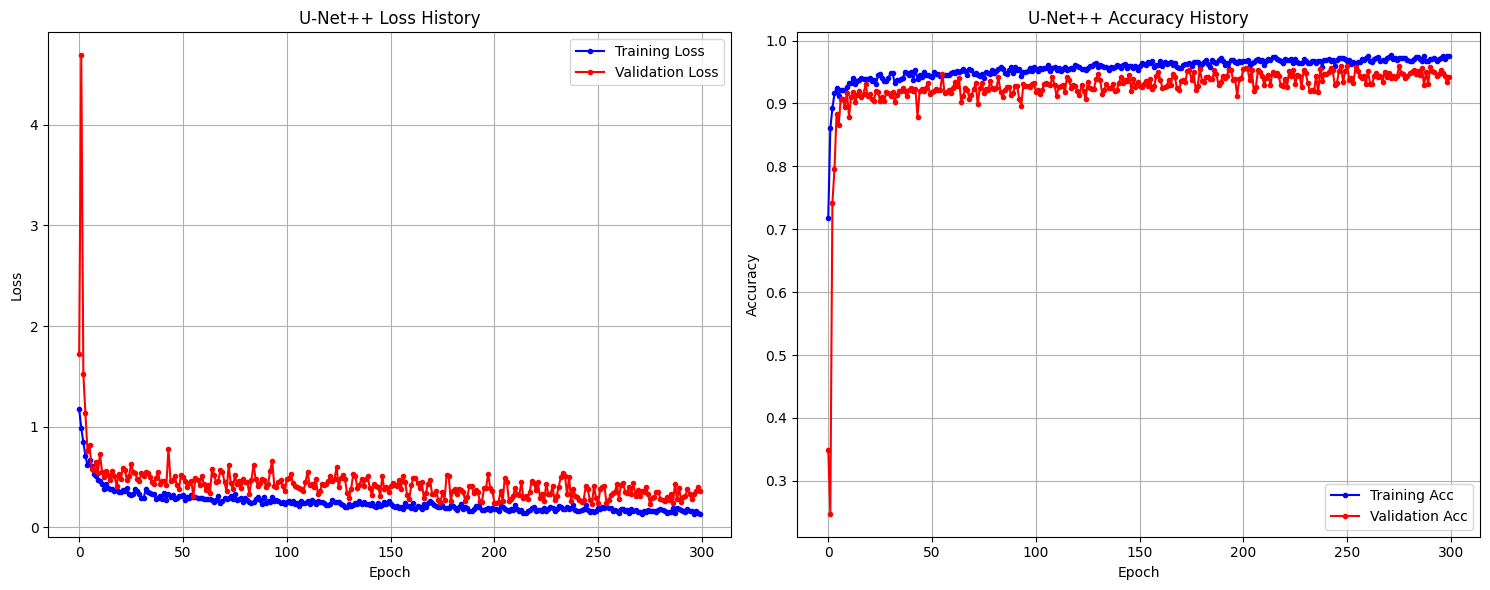

In [24]:
# -------------------------------------------------------------------------
# 4. U-Net++ 단독 결과 그래프
# -------------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. U-Net++ Loss 그래프
axes[0].plot(train_losses_plus, label='Training Loss', marker='.', color='blue')
axes[0].plot(val_losses_plus, label='Validation Loss', marker='.', color='red')
axes[0].set_title('U-Net++ Loss History')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# 2. U-Net++ Accuracy 그래프
axes[1].plot(train_accs_plus, label='Training Acc', marker='.', color='blue')
axes[1].plot(val_accs_plus, label='Validation Acc', marker='.', color='red')
axes[1].set_title('U-Net++ Accuracy History')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [28]:
import numpy as np
import torch
from PIL import Image
from skimage.io import imread
import matplotlib.pyplot as plt

def get_output1(model, preproc, image_path, output_path, label_path=None):
    # 1. 원본 이미지 로드
    origin_img = imread(image_path)
    data = {"image": origin_img}

    # 2. 전처리 및 텐서 변환
    processed = preproc(**data)
    input_tensor = torch.tensor(processed["image"] / 255.0, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)

    # 3. GPU 이동 (이전 단계의 수정 사항 적용)
    device = next(model.parameters()).device
    input_tensor = input_tensor.to(device)

    # 4. 모델 추론
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)

    # 5. 예측값 처리 (GPU -> CPU -> Numpy)
    # prediction_raw: 0~255 사이의 값 (시각화용)
    prediction_raw = (output[0].squeeze().cpu().numpy() > 0.5).astype(np.uint8) * 255
    
    # prediction: 0 or 1 (IoU 계산용) - 필요에 따라 0/255로 유지해도 되지만, 보통 IoU 계산엔 정규화된 값이 쓰일 수 있음
    # 여기서는 호출부의 calculate_iou_score 로직에 맞게 넘겨주면 됩니다. 
    # 보통 마스크 자체를 넘기므로 prediction_raw를 그대로 사용하거나 255로 나눈 값을 사용합니다.
    prediction = prediction_raw 

    # 6. 정답(Label) 로드 (label_path가 있을 경우)
    target = None
    if label_path:
        target = imread(label_path)
        if len(target.shape) == 3:
            target = target[:, :, 0]
    
    # [수정] 학습 때와 동일하게 '도로(7)'만 1(또는 255)로 만들고 나머지는 0으로 처리
        target = (target == 7).astype(np.uint8) * 255

    # 7. 시각화 (Blending)
    pred_img = Image.fromarray(prediction_raw).convert('L')
    background = Image.fromarray(origin_img).convert('RGBA')
    pred_img = pred_img.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    blended = Image.blend(background, pred_img, alpha=0.5)

    # 8. 결과 저장 및 시각화
    blended.save(output_path)
    
    # 화면 출력 (선택 사항)
    plt.imshow(np.array(blended))
    plt.axis('off')
    plt.show()

    # 9. 3개의 값 반환 (호출부 요구사항: output, prediction, target)
    return blended, prediction, target

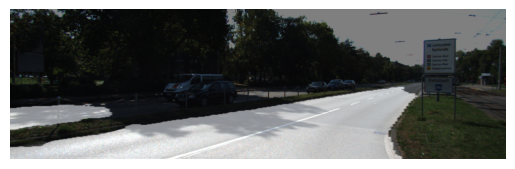

IoU : 0.504553


np.float64(0.5045528580402803)

In [29]:
output, prediction, target = get_output1(
     model_plus,
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'/result_{str(i).zfill(3)}++.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

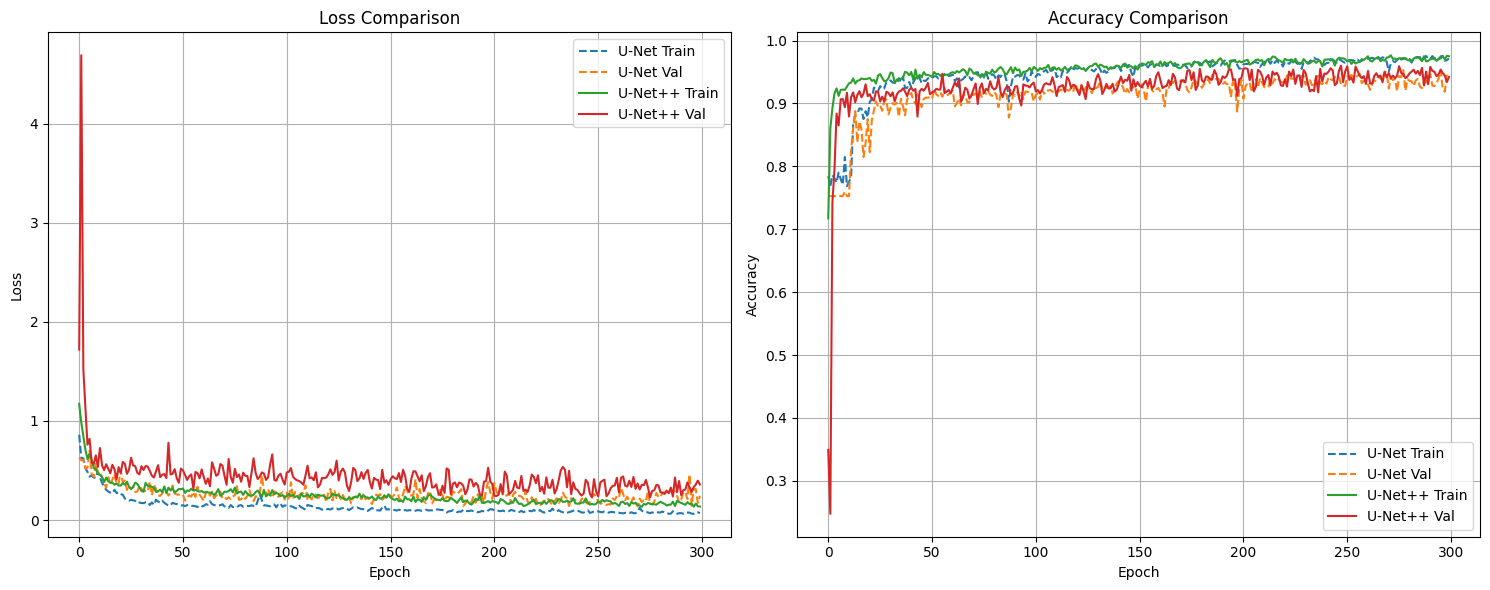

In [27]:
# -------------------------------------------------------------------------
# 5. 결과 비교 그래프 (U-Net vs U-Net++)
# -------------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Loss 비교
axes[0].plot(train_losses, label='U-Net Train', linestyle='--')
axes[0].plot(val_losses, label='U-Net Val', linestyle='--')
axes[0].plot(train_losses_plus, label='U-Net++ Train')
axes[0].plot(val_losses_plus, label='U-Net++ Val')
axes[0].set_title('Loss Comparison')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy 비교
axes[1].plot(train_accs, label='U-Net Train', linestyle='--')
axes[1].plot(val_accs, label='U-Net Val', linestyle='--')
axes[1].plot(train_accs_plus, label='U-Net++ Train')
axes[1].plot(val_accs_plus, label='U-Net++ Val')
axes[1].set_title('Accuracy Comparison')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## 실험 결과

1. U-Net 학습 결과  

![Unet 결과](./u%20결과.png)  

| 지표 | 값 |
| :--- | :--- |
| IoU | 0.499784 |  

- 예측 결과를 확인해보면 비교적 도로를 잘 찾아낸 것을 확인할 수 있다.

2. U-Net++ 학습 결과  

![Unet++ 그래프](./u++%20그래프.png)  

![Unet++ 결과](./u++%20결과.png)  

| 지표 | 값 |
| :--- | :--- |
| IoU | 0.504553 |  

- 학습 그래프를 확인해 본 결과 과적합 없이 학습이 잘 진행된 것을 볼 수 있다. 
- 예측 결과도 확인해보면 비교적 도로를 잘 찾아낸 것을 확인할 수 있다.

3. U-Net vs U-Net++ 결과 비교  

![Unet 통합 그래프](./통합%20그래프.png)  

![Unet 결과](./u%20결과.png) | ![Unet++ 결과](./u++%20결과.png)

| 지표 | U-Net | U-Net++ |
| :--- | :--- | :--- |
| IoU | 0.499784 | 0.504553 |


- 전체적으로 학습을 확인해보면 잘 학습이 되었으나 과적합이 발생하지 않았고 loss값과 acc 값이 계속 증가할 수 있어보이므로 좀더 학습을 진행한다면 성능이 향상될 것으로 보인다.
- U net은 그림자 지지 않은 부분을 잘 검출하였고 U Net++은 그림자 진 부분을 잘 검출한 것을 볼 수 있었다.
- IoU를 비교해보면 Unet++의 결과가 0.5%p정도 높게 나온것을 확인할 수 있다.
- 하지만 예측 결과 이미지를 직접 비교해보면 크게 향상된것이 맞는지 의문이 든다.


4. 개선할 사항  

- 결과를 확인해보면 각 객체의 끝 부분이 잘 예측되지 않은 것을 확인할 수 있다.
- 이를 해결하기 위해 Boundary IoU를 따로 뽑아내서 학습하는데 사용한다면 끝 부분에 대해 예측이 잘 이뤄지지 않을까 예상된다.